### Modeling with features complete.csv and tests_latest_state_level.csv which contains Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated and coronaenquirycalls,cumulativepeopleinquarantine,negative,numcallsstatehelpline,numicubeds,numisolationbeds,numventilators,populationncp2019projection,positive,source1,source2,state,tagpeopleinquarantine,tagtotaltested,testpositivityrate,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,updatedon,_d415a


#### Merge these 2 files at a state level with common key as Date.

# Single Step Deep Learning Forecasts for West Bengal, Delhi, and Gujrat

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import csv
import matplotlib.pyplot as plt
from sklearn import preprocessing
import mplcursors
import datetime
from pmdarima.arima import auto_arima
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from tslearn.svm import TimeSeriesSVR
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
import sys

### TensorFlow Libraries Import

In [2]:
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector
from tensorflow.python.keras import Sequential 

from tensorflow.python.keras.layers import TimeDistributed,Flatten, Bidirectional, ConvLSTM2D
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D

### Setting the start and end dates

In [3]:
startDate ='2020-01-30'
endDate = '2020-06-05'

In [5]:
path = '/Users/shachatt1/Desktop/sharmi/gitfolder/covid-19-analysis/'
sys.path.append(path)
df1 = pd.read_csv('covid-19-latest_6_june/tests_latest_state_level.csv')
df1 = df1.drop(columns=['_d415a', 'source2'])
df1['Date'] = pd.to_datetime(df1['updatedon'], infer_datetime_format=True)

In [6]:
df1.dtypes

coronaenquirycalls                          float64
cumulativepeopleinquarantine                float64
negative                                    float64
numcallsstatehelpline                       float64
numicubeds                                  float64
numisolationbeds                            float64
numventilators                              float64
populationncp2019projection                 float64
positive                                    float64
source1                                      object
state                                        object
tagpeopleinquarantine                        object
tagtotaltested                               object
testpositivityrate                          float64
testspermillion                             float64
testsperpositivecase                        float64
testsperthousand                            float64
totaln95masks                               float64
totalpeoplecurrentlyinquarantine            float64
totalpeopler

In [7]:
df1.shape

(1730, 25)

In [8]:
df1.columns

Index(['coronaenquirycalls', 'cumulativepeopleinquarantine', 'negative',
       'numcallsstatehelpline', 'numicubeds', 'numisolationbeds',
       'numventilators', 'populationncp2019projection', 'positive', 'source1',
       'state', 'tagpeopleinquarantine', 'tagtotaltested',
       'testpositivityrate', 'testspermillion', 'testsperpositivecase',
       'testsperthousand', 'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'updatedon', 'Date'],
      dtype='object')

In [9]:
df1[["testpositivityrate"]] = df1[["testpositivityrate"]].apply(pd.to_numeric)

df1 = df1.drop(columns=['updatedon'])

In [10]:
stateList = df1['state'].values

unique_states = df1['state'].unique()
df_org = df1.copy(deep=False)

all_state_List =[]

#indexing the data based on date
for i in range(0, len(unique_states)):
    df1 = df_org.copy(deep=False)
    df1 = df1[df1['state'] == unique_states[i]]
    df1 = df1.drop_duplicates(subset='Date', keep="last")
    date_index = pd.date_range(start=startDate, end=endDate)
    df1= df1.set_index('Date').reindex(date_index).fillna(0).rename_axis('Date').reset_index()
    df1 = df1.replace(0, np.nan)

    df1 = df1.ffill(axis =0)
    df1 = df1.replace(np.nan, 0)

    df1 = df1.reset_index()
    df1['state'] = unique_states[i]

    all_state_List.append(df1)

all_states_df = pd.concat(all_state_List)
all_states_df.reset_index(drop=True)
all_states_df.to_csv('covid-19-latest_6_june/transfm_1_tests_latest_state_level.csv', index=False)

In [11]:
df2 = pd.read_csv('covid-19-latest_6_june/complete.csv')

In [12]:
np.shape(df2)

(2670, 7)

In [13]:
df2.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated
0,2020-01-30,Kerala,10.8505,76.2711,1,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3,0,0


In [14]:
df2.dtypes

Date                          object
Name of State / UT            object
Latitude                     float64
Longitude                    float64
Total Confirmed cases          int64
Death                          int64
Cured/Discharged/Migrated      int64
dtype: object

In [15]:
df2['Date'] = pd.to_datetime(df2['Date'], infer_datetime_format=True)

#### Printing all unique state names

In [16]:
print(unique_states)
print(len(unique_states))

['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra and Nagar Haveli and Daman and Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Ladakh' 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya'
 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil Nadu' 'Telangana' 'Tripura' 'Uttar Pradesh' 'Uttarakhand'
 'West Bengal']
35


In [17]:
list_state_all = []
for j in range(0, len(unique_states)):
    state_data = df2[df2['Name of State / UT'] == unique_states[j]]
    state_testing = all_states_df[all_states_df['state'] == unique_states[j]]
    result = pd.merge(state_data, state_testing, left_on = 'Date', right_on = 'Date', how ='outer')
    result = result.sort_values(by='Date', ascending=True)
    result['Active Cases'] = result['Total Confirmed cases'] - result['Cured/Discharged/Migrated'] - result['Death']
    fname = unique_states[j] + '.csv'
    result.to_csv('all_states/'+ fname)
    list_state_all.append(result)

In [18]:
df_state_all = pd.concat(list_state_all)
df_state_all.to_csv('all_states/all.csv')

In [19]:
df_state_all.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,index,coronaenquirycalls,cumulativepeopleinquarantine,...,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,Active Cases
72,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
73,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
74,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75,2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
76,2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [20]:
df_state_all.shape

(4480, 32)

In [21]:
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
df_state_all.shape

(4480, 29)

In [22]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

In [23]:
print(stateName)
dataset.head(15)

Delhi


,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,index,coronaenquirycalls,cumulativepeopleinquarantine,...,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,Active Cases
23,2020-03-25,Delhi,28.7041,77.1025,31.0,1.0,6.0,55,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,24.0
24,2020-03-26,Delhi,28.7041,77.1025,36.0,1.0,6.0,56,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,29.0
25,2020-03-27,Delhi,28.7041,77.1025,36.0,1.0,6.0,57,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,29.0
26,2020-03-28,Delhi,28.7041,77.1025,39.0,1.0,6.0,58,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,32.0
27,2020-03-29,Delhi,28.7041,77.1025,39.0,2.0,6.0,59,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,31.0
28,2020-03-30,Delhi,28.7041,77.1025,53.0,2.0,6.0,60,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,45.0
29,2020-03-31,Delhi,28.7041,77.1025,97.0,2.0,6.0,61,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,89.0
30,2020-04-01,Delhi,28.7041,77.1025,152.0,2.0,6.0,62,0.0,0.0,...,132.0,0.0,0.13,0.0,0.0,0.0,0.0,2621.0,2621.0,144.0
31,2020-04-02,Delhi,28.7041,77.1025,152.0,2.0,6.0,63,0.0,0.0,...,132.0,0.0,0.13,0.0,0.0,0.0,0.0,2621.0,2621.0,144.0
32,2020-04-03,Delhi,28.7041,77.1025,219.0,4.0,8.0,64,0.0,0.0,...,132.0,0.0,0.13,0.0,0.0,0.0,0.0,2621.0,2621.0,207.0


In [24]:
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]


# LSTM based Prediction for Delhi with all features

In [25]:
# # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
   
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # NAN value rows are dropped
    if dropnan:
        agg.dropna(inplace=True)
    return agg



dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]


In [26]:
dataset.head()


,Total Confirmed cases,Death,Cured/Discharged/Migrated,coronaenquirycalls,cumulativepeopleinquarantine,negative,numcallsstatehelpline,numicubeds,numisolationbeds,numventilators,...,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,Active Cases
23,31.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
24,36.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
25,36.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
26,39.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
27,39.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0


In [56]:
dataset.dtypes

Total Confirmed cases                float64
Death                                float64
Cured/Discharged/Migrated            float64
coronaenquirycalls                   float64
cumulativepeopleinquarantine         float64
negative                             float64
numcallsstatehelpline                float64
numicubeds                           float64
numisolationbeds                     float64
numventilators                       float64
populationncp2019projection          float64
positive                             float64
testpositivityrate                   float64
testspermillion                      float64
testsperpositivecase                 float64
testsperthousand                     float64
totaln95masks                        float64
totalpeoplecurrentlyinquarantine     float64
totalpeoplereleasedfromquarantine    float64
totalppe                             float64
totaltested                          float64
unconfirmed                          float64
Active Cas

In [57]:
np.shape(dataset)


(73, 23)

In [58]:
#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

43
(43, 24)
(29, 24)
(43, 23) (43,) (29, 23) (29,)
Train and Test Shapes (43, 1, 23) (43,) (29, 1, 23) (29,)
Epoch 1/1500
1/1 - 1s - loss: 0.0699 - val_loss: 0.5102
Epoch 2/1500
1/1 - 0s - loss: 0.0653 - val_loss: 0.5037
Epoch 3/1500
1/1 - 0s - loss: 0.0614 - val_loss: 0.4971
Epoch 4/1500
1/1 - 0s - loss: 0.0575 - val_loss: 0.4902
Epoch 5/1500
1/1 - 0s - loss: 0.0540 - val_loss: 0.4831
Epoch 6/1500
1/1 - 0s - loss: 0.0514 - val_loss: 0.4758
Epoch 7/1500
1/1 - 0s - loss: 0.0491 - val_loss: 0.4684
Epoch 8/1500
1/1 - 0s - loss: 0.0469 - val_loss: 0.4607
Epoch 9/1500
1/1 - 0s - loss: 0.0451 - val_loss: 0.4527
Epoch 10/1500
1/1 - 0s - loss: 0.0432 - val_loss: 0.4443
Epoch 11/1500
1/1 - 0s - loss: 0.0418 - val_loss: 0.4358
Epoch 12/1500
1/1 - 0s - loss: 0.0411 - val_loss: 0.4274
Epoch 13/1500
1/1 - 0s - loss: 0.0407 - val_loss: 0.4193
Epoch 14/1500
1/1 - 0s - loss: 0.0407 - val_loss: 0.4121
Epoch 15/1500
1/1 - 0s - loss: 0.0410 - val_loss: 0.4059
Epoch 16/1500
1/1 - 0s - loss: 0.0412 - val_l

1/1 - 0s - loss: 0.0033 - val_loss: 0.0241
Epoch 143/1500
1/1 - 0s - loss: 0.0026 - val_loss: 0.0188
Epoch 144/1500
1/1 - 0s - loss: 0.0029 - val_loss: 0.0197
Epoch 145/1500
1/1 - 0s - loss: 0.0027 - val_loss: 0.0268
Epoch 146/1500
1/1 - 0s - loss: 0.0029 - val_loss: 0.0249
Epoch 147/1500
1/1 - 0s - loss: 0.0026 - val_loss: 0.0222
Epoch 148/1500
1/1 - 0s - loss: 0.0028 - val_loss: 0.0256
Epoch 149/1500
1/1 - 0s - loss: 0.0026 - val_loss: 0.0360
Epoch 150/1500
1/1 - 0s - loss: 0.0029 - val_loss: 0.0340
Epoch 151/1500
1/1 - 0s - loss: 0.0025 - val_loss: 0.0307
Epoch 152/1500
1/1 - 0s - loss: 0.0028 - val_loss: 0.0350
Epoch 153/1500
1/1 - 0s - loss: 0.0025 - val_loss: 0.0441
Epoch 154/1500
1/1 - 0s - loss: 0.0031 - val_loss: 0.0391
Epoch 155/1500
1/1 - 0s - loss: 0.0025 - val_loss: 0.0302
Epoch 156/1500
1/1 - 0s - loss: 0.0030 - val_loss: 0.0308
Epoch 157/1500
1/1 - 0s - loss: 0.0027 - val_loss: 0.0394
Epoch 158/1500
1/1 - 0s - loss: 0.0029 - val_loss: 0.0383
Epoch 159/1500
1/1 - 0s - los

Epoch 284/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1203
Epoch 285/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1150
Epoch 286/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1139
Epoch 287/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1172
Epoch 288/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1203
Epoch 289/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1158
Epoch 290/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1172
Epoch 291/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1230
Epoch 292/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1219
Epoch 293/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1149
Epoch 294/1500
1/1 - 0s - loss: 0.0021 - val_loss: 0.1203
Epoch 295/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1179
Epoch 296/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1147
Epoch 297/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1154
Epoch 298/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1196
Epoch 299/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1232
Epoch 300/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1190
Epoch 301/1500

1/1 - 0s - loss: 0.0019 - val_loss: 0.1417
Epoch 426/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1459
Epoch 427/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1417
Epoch 428/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1413
Epoch 429/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1490
Epoch 430/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1478
Epoch 431/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1485
Epoch 432/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1527
Epoch 433/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1466
Epoch 434/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1459
Epoch 435/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1478
Epoch 436/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1492
Epoch 437/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1462
Epoch 438/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1526
Epoch 439/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1524
Epoch 440/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1491
Epoch 441/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1550
Epoch 442/1500
1/1 - 0s - los

Epoch 567/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1587
Epoch 568/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1545
Epoch 569/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1545
Epoch 570/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1581
Epoch 571/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1570
Epoch 572/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1574
Epoch 573/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1626
Epoch 574/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1561
Epoch 575/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1593
Epoch 576/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1580
Epoch 577/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1570
Epoch 578/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1575
Epoch 579/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1609
Epoch 580/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1615
Epoch 581/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1622
Epoch 582/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1574
Epoch 583/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1573
Epoch 584/1500

1/1 - 0s - loss: 0.0026 - val_loss: 0.1709
Epoch 709/1500
1/1 - 0s - loss: 0.0025 - val_loss: 0.1583
Epoch 710/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1567
Epoch 711/1500
1/1 - 0s - loss: 0.0022 - val_loss: 0.1654
Epoch 712/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1628
Epoch 713/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1549
Epoch 714/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1572
Epoch 715/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1621
Epoch 716/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1545
Epoch 717/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1566
Epoch 718/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1577
Epoch 719/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1579
Epoch 720/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1630
Epoch 721/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1573
Epoch 722/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1617
Epoch 723/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1566
Epoch 724/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1531
Epoch 725/1500
1/1 - 0s - los

Epoch 850/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1653
Epoch 851/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1732
Epoch 852/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1693
Epoch 853/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1618
Epoch 854/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1635
Epoch 855/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1730
Epoch 856/1500
1/1 - 0s - loss: 0.0025 - val_loss: 0.1693
Epoch 857/1500
1/1 - 0s - loss: 0.0022 - val_loss: 0.1541
Epoch 858/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1519
Epoch 859/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1609
Epoch 860/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1656
Epoch 861/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1588
Epoch 862/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1568
Epoch 863/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1633
Epoch 864/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1682
Epoch 865/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1618
Epoch 866/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1618
Epoch 867/1500

1/1 - 0s - loss: 0.0020 - val_loss: 0.1638
Epoch 992/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1517
Epoch 993/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1496
Epoch 994/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1576
Epoch 995/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1617
Epoch 996/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1572
Epoch 997/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1586
Epoch 998/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1675
Epoch 999/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1658
Epoch 1000/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1559
Epoch 1001/1500
1/1 - 0s - loss: 0.0021 - val_loss: 0.1561
Epoch 1002/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1640
Epoch 1003/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1612
Epoch 1004/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1491
Epoch 1005/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1475
Epoch 1006/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1554
Epoch 1007/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1611
Epoch 1008/1500
1/1 -

Epoch 1131/1500
1/1 - 0s - loss: 0.0021 - val_loss: 0.1651
Epoch 1132/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1670
Epoch 1133/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1594
Epoch 1134/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1588
Epoch 1135/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1646
Epoch 1136/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1606
Epoch 1137/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1557
Epoch 1138/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1584
Epoch 1139/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1628
Epoch 1140/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1592
Epoch 1141/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1570
Epoch 1142/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1622
Epoch 1143/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1625
Epoch 1144/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1592
Epoch 1145/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1632
Epoch 1146/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1655
Epoch 1147/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.16

Epoch 1270/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1597
Epoch 1271/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1524
Epoch 1272/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1496
Epoch 1273/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1566
Epoch 1274/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1649
Epoch 1275/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1625
Epoch 1276/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1588
Epoch 1277/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1626
Epoch 1278/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1713
Epoch 1279/1500
1/1 - 0s - loss: 0.0022 - val_loss: 0.1689
Epoch 1280/1500
1/1 - 0s - loss: 0.0020 - val_loss: 0.1568
Epoch 1281/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1531
Epoch 1282/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1594
Epoch 1283/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1618
Epoch 1284/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1585
Epoch 1285/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1575
Epoch 1286/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.16

Epoch 1409/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1612
Epoch 1410/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1631
Epoch 1411/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1694
Epoch 1412/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1651
Epoch 1413/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1612
Epoch 1414/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1646
Epoch 1415/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1717
Epoch 1416/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1681
Epoch 1417/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1581
Epoch 1418/1500
1/1 - 0s - loss: 0.0023 - val_loss: 0.1602
Epoch 1419/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1705
Epoch 1420/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1699
Epoch 1421/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1595
Epoch 1422/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1570
Epoch 1423/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1624
Epoch 1424/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1641
Epoch 1425/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.15

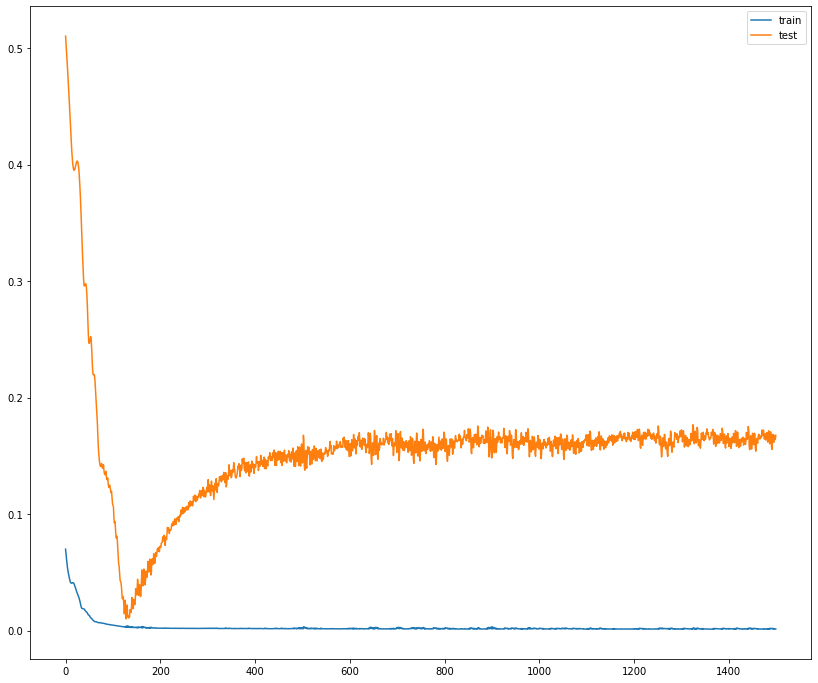

(43, 1, 23) (43,) (29, 23) (29,)


In [59]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
print(split_factor)
train = values[:split_factor, :]
test = values[split_factor:, :]

print(np.shape(train))
print(np.shape(test))

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Train and Test Shapes", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design Stacked LSTM networks
model = Sequential()

model.add(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=1500, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)




In [60]:
print(np.shape(y_predict))

(29, 1)


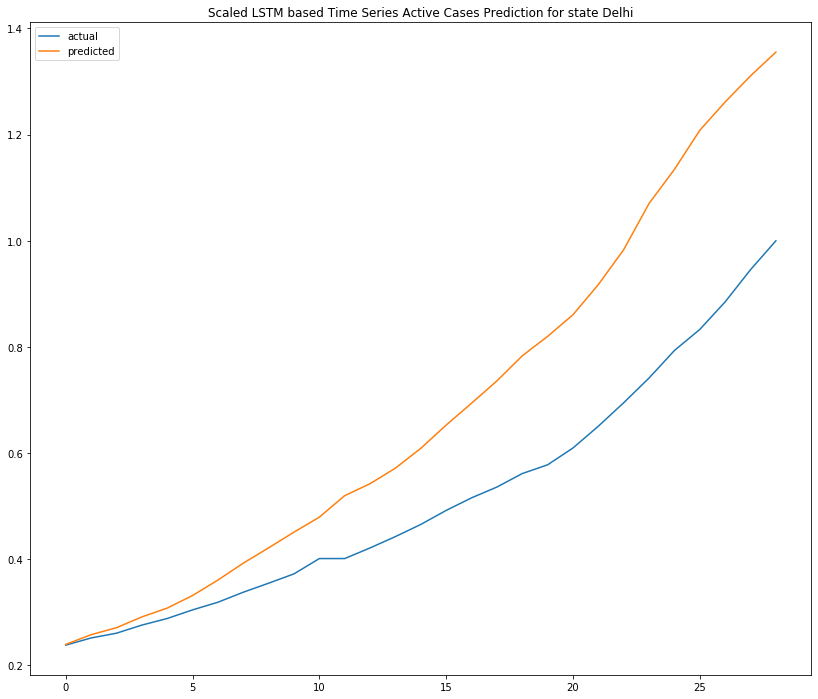

Test RMSE: 0.210
Test RMSE: 5243.130


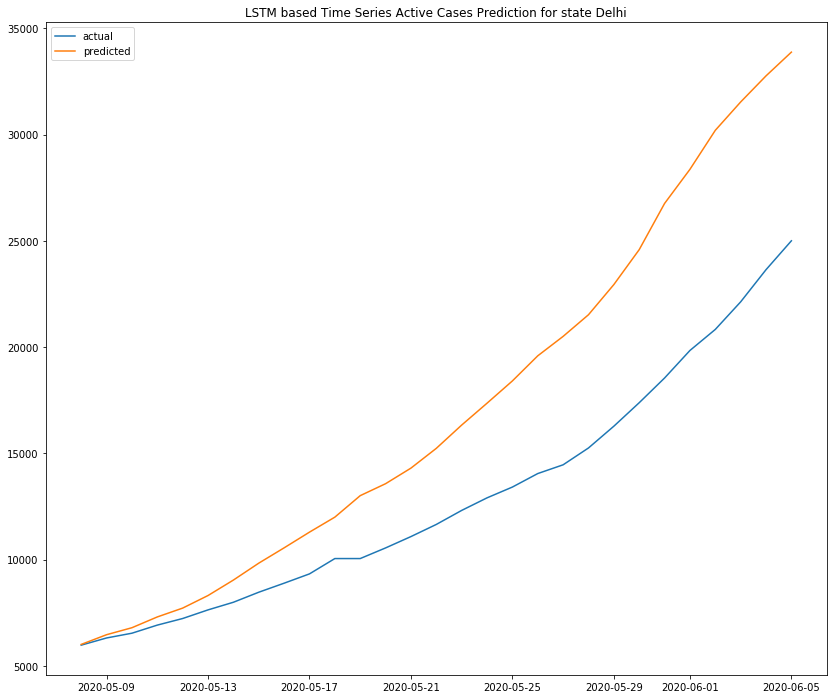

In [61]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Bi-Directional LSTM based Prediction for Delhi (Expanding Window width 3) with all features

In [62]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]
print(np.shape(dataset))

(97, 23)


In [63]:
#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')
print(np.shape(values))
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

(97, 23)


Train and Test Shapes (58, 1, 23) (58,) (37, 1, 23) (37,)
Epoch 1/1500
1/1 - 0s - loss: 0.0205 - val_loss: 0.3962
Epoch 2/1500
1/1 - 0s - loss: 0.0181 - val_loss: 0.3804
Epoch 3/1500
1/1 - 0s - loss: 0.0161 - val_loss: 0.3654
Epoch 4/1500
1/1 - 0s - loss: 0.0138 - val_loss: 0.3508
Epoch 5/1500
1/1 - 0s - loss: 0.0120 - val_loss: 0.3371
Epoch 6/1500
1/1 - 0s - loss: 0.0111 - val_loss: 0.3251
Epoch 7/1500
1/1 - 0s - loss: 0.0107 - val_loss: 0.3144
Epoch 8/1500
1/1 - 0s - loss: 0.0106 - val_loss: 0.3067
Epoch 9/1500
1/1 - 0s - loss: 0.0105 - val_loss: 0.3020
Epoch 10/1500
1/1 - 0s - loss: 0.0101 - val_loss: 0.2994
Epoch 11/1500
1/1 - 0s - loss: 0.0094 - val_loss: 0.2986
Epoch 12/1500
1/1 - 0s - loss: 0.0089 - val_loss: 0.2994
Epoch 13/1500
1/1 - 0s - loss: 0.0083 - val_loss: 0.3005
Epoch 14/1500
1/1 - 0s - loss: 0.0079 - val_loss: 0.3012
Epoch 15/1500
1/1 - 0s - loss: 0.0076 - val_loss: 0.3009
Epoch 16/1500
1/1 - 0s - loss: 0.0075 - val_loss: 0.2994
Epoch 17/1500
1/1 - 0s - loss: 0.0073 -

1/1 - 0s - loss: 0.0012 - val_loss: 0.1742
Epoch 144/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1738
Epoch 145/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1695
Epoch 146/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1690
Epoch 147/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1725
Epoch 148/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1727
Epoch 149/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1697
Epoch 150/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1696
Epoch 151/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1717
Epoch 152/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1710
Epoch 153/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1686
Epoch 154/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1694
Epoch 155/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1692
Epoch 156/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1678
Epoch 157/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1686
Epoch 158/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1682
Epoch 159/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1674
Epoch 160/1500
1/1 - 0s - los

Epoch 284/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1504
Epoch 285/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1529
Epoch 286/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1521
Epoch 287/1500
1/1 - 0s - loss: 9.2630e-04 - val_loss: 0.1493
Epoch 288/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1500
Epoch 289/1500
1/1 - 0s - loss: 9.6945e-04 - val_loss: 0.1522
Epoch 290/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1505
Epoch 291/1500
1/1 - 0s - loss: 9.1360e-04 - val_loss: 0.1490
Epoch 292/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1504
Epoch 293/1500
1/1 - 0s - loss: 9.1634e-04 - val_loss: 0.1511
Epoch 294/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1487
Epoch 295/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1491
Epoch 296/1500
1/1 - 0s - loss: 9.3562e-04 - val_loss: 0.1508
Epoch 297/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1490
Epoch 298/1500
1/1 - 0s - loss: 9.1281e-04 - val_loss: 0.1478
Epoch 299/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1499
Epoch 300/1500
1/1 - 0s - loss: 0.0010 - val_los

Epoch 421/1500
1/1 - 0s - loss: 9.5322e-04 - val_loss: 0.1206
Epoch 422/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1233
Epoch 423/1500
1/1 - 0s - loss: 9.6674e-04 - val_loss: 0.1230
Epoch 424/1500
1/1 - 0s - loss: 9.1714e-04 - val_loss: 0.1198
Epoch 425/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1201
Epoch 426/1500
1/1 - 0s - loss: 9.3923e-04 - val_loss: 0.1227
Epoch 427/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1216
Epoch 428/1500
1/1 - 0s - loss: 9.4348e-04 - val_loss: 0.1183
Epoch 429/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1189
Epoch 430/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1223
Epoch 431/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1223
Epoch 432/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1194
Epoch 433/1500
1/1 - 0s - loss: 9.6004e-04 - val_loss: 0.1189
Epoch 434/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1212
Epoch 435/1500
1/1 - 0s - loss: 9.0802e-04 - val_loss: 0.1207
Epoch 436/1500
1/1 - 0s - loss: 8.8455e-04 - val_loss: 0.1177
Epoch 437/1500
1/1 - 0s - loss: 9.8442e-

Epoch 555/1500
1/1 - 0s - loss: 6.8977e-04 - val_loss: 0.0712
Epoch 556/1500
1/1 - 0s - loss: 8.2067e-04 - val_loss: 0.0701
Epoch 557/1500
1/1 - 0s - loss: 6.9937e-04 - val_loss: 0.0706
Epoch 558/1500
1/1 - 0s - loss: 6.9798e-04 - val_loss: 0.0713
Epoch 559/1500
1/1 - 0s - loss: 6.8265e-04 - val_loss: 0.0703
Epoch 560/1500
1/1 - 0s - loss: 6.7664e-04 - val_loss: 0.0698
Epoch 561/1500
1/1 - 0s - loss: 6.6757e-04 - val_loss: 0.0703
Epoch 562/1500
1/1 - 0s - loss: 7.6442e-04 - val_loss: 0.0682
Epoch 563/1500
1/1 - 0s - loss: 7.5877e-04 - val_loss: 0.0688
Epoch 564/1500
1/1 - 0s - loss: 6.6774e-04 - val_loss: 0.0698
Epoch 565/1500
1/1 - 0s - loss: 7.7492e-04 - val_loss: 0.0680
Epoch 566/1500
1/1 - 0s - loss: 7.6914e-04 - val_loss: 0.0684
Epoch 567/1500
1/1 - 0s - loss: 6.9306e-04 - val_loss: 0.0701
Epoch 568/1500
1/1 - 0s - loss: 9.1099e-04 - val_loss: 0.0679
Epoch 569/1500
1/1 - 0s - loss: 6.6424e-04 - val_loss: 0.0661
Epoch 570/1500
1/1 - 0s - loss: 7.8185e-04 - val_loss: 0.0670
Epoch 57

Epoch 688/1500
1/1 - 0s - loss: 7.7735e-04 - val_loss: 0.0400
Epoch 689/1500
1/1 - 0s - loss: 8.7317e-04 - val_loss: 0.0407
Epoch 690/1500
1/1 - 0s - loss: 6.7449e-04 - val_loss: 0.0425
Epoch 691/1500
1/1 - 0s - loss: 9.4372e-04 - val_loss: 0.0418
Epoch 692/1500
1/1 - 0s - loss: 6.4887e-04 - val_loss: 0.0404
Epoch 693/1500
1/1 - 0s - loss: 9.6748e-04 - val_loss: 0.0411
Epoch 694/1500
1/1 - 0s - loss: 7.4848e-04 - val_loss: 0.0428
Epoch 695/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.0425
Epoch 696/1500
1/1 - 0s - loss: 9.3905e-04 - val_loss: 0.0402
Epoch 697/1500
1/1 - 0s - loss: 7.6586e-04 - val_loss: 0.0400
Epoch 698/1500
1/1 - 0s - loss: 8.1400e-04 - val_loss: 0.0416
Epoch 699/1500
1/1 - 0s - loss: 7.7332e-04 - val_loss: 0.0412
Epoch 700/1500
1/1 - 0s - loss: 6.2450e-04 - val_loss: 0.0407
Epoch 701/1500
1/1 - 0s - loss: 6.8707e-04 - val_loss: 0.0416
Epoch 702/1500
1/1 - 0s - loss: 6.9971e-04 - val_loss: 0.0409
Epoch 703/1500
1/1 - 0s - loss: 6.8158e-04 - val_loss: 0.0406
Epoch 704/15

Epoch 821/1500
1/1 - 0s - loss: 9.2628e-04 - val_loss: 0.0360
Epoch 822/1500
1/1 - 0s - loss: 7.7939e-04 - val_loss: 0.0373
Epoch 823/1500
1/1 - 0s - loss: 8.8220e-04 - val_loss: 0.0372
Epoch 824/1500
1/1 - 0s - loss: 9.1154e-04 - val_loss: 0.0361
Epoch 825/1500
1/1 - 0s - loss: 6.8291e-04 - val_loss: 0.0359
Epoch 826/1500
1/1 - 0s - loss: 7.2428e-04 - val_loss: 0.0366
Epoch 827/1500
1/1 - 0s - loss: 6.7857e-04 - val_loss: 0.0364
Epoch 828/1500
1/1 - 0s - loss: 6.2350e-04 - val_loss: 0.0356
Epoch 829/1500
1/1 - 0s - loss: 7.6396e-04 - val_loss: 0.0359
Epoch 830/1500
1/1 - 0s - loss: 5.9928e-04 - val_loss: 0.0364
Epoch 831/1500
1/1 - 0s - loss: 7.8894e-04 - val_loss: 0.0356
Epoch 832/1500
1/1 - 0s - loss: 6.2612e-04 - val_loss: 0.0356
Epoch 833/1500
1/1 - 0s - loss: 6.1481e-04 - val_loss: 0.0360
Epoch 834/1500
1/1 - 0s - loss: 6.7021e-04 - val_loss: 0.0356
Epoch 835/1500
1/1 - 0s - loss: 6.3483e-04 - val_loss: 0.0361
Epoch 836/1500
1/1 - 0s - loss: 6.0877e-04 - val_loss: 0.0360
Epoch 83

1/1 - 0s - loss: 9.4959e-04 - val_loss: 0.0398
Epoch 954/1500
1/1 - 0s - loss: 7.2350e-04 - val_loss: 0.0401
Epoch 955/1500
1/1 - 0s - loss: 9.1310e-04 - val_loss: 0.0401
Epoch 956/1500
1/1 - 0s - loss: 6.9881e-04 - val_loss: 0.0401
Epoch 957/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.0401
Epoch 958/1500
1/1 - 0s - loss: 9.3231e-04 - val_loss: 0.0401
Epoch 959/1500
1/1 - 0s - loss: 8.1970e-04 - val_loss: 0.0400
Epoch 960/1500
1/1 - 0s - loss: 9.8604e-04 - val_loss: 0.0397
Epoch 961/1500
1/1 - 0s - loss: 6.5055e-04 - val_loss: 0.0399
Epoch 962/1500
1/1 - 0s - loss: 7.3406e-04 - val_loss: 0.0404
Epoch 963/1500
1/1 - 0s - loss: 5.9702e-04 - val_loss: 0.0407
Epoch 964/1500
1/1 - 0s - loss: 6.2974e-04 - val_loss: 0.0407
Epoch 965/1500
1/1 - 0s - loss: 6.7252e-04 - val_loss: 0.0405
Epoch 966/1500
1/1 - 0s - loss: 5.8728e-04 - val_loss: 0.0405
Epoch 967/1500
1/1 - 0s - loss: 7.2054e-04 - val_loss: 0.0404
Epoch 968/1500
1/1 - 0s - loss: 5.8482e-04 - val_loss: 0.0406
Epoch 969/1500
1/1 - 0s - l

Epoch 1085/1500
1/1 - 0s - loss: 6.6703e-04 - val_loss: 0.0449
Epoch 1086/1500
1/1 - 0s - loss: 5.6091e-04 - val_loss: 0.0449
Epoch 1087/1500
1/1 - 0s - loss: 5.7308e-04 - val_loss: 0.0455
Epoch 1088/1500
1/1 - 0s - loss: 7.7820e-04 - val_loss: 0.0451
Epoch 1089/1500
1/1 - 0s - loss: 5.9317e-04 - val_loss: 0.0448
Epoch 1090/1500
1/1 - 0s - loss: 8.3201e-04 - val_loss: 0.0453
Epoch 1091/1500
1/1 - 0s - loss: 5.4002e-04 - val_loss: 0.0457
Epoch 1092/1500
1/1 - 0s - loss: 8.0528e-04 - val_loss: 0.0450
Epoch 1093/1500
1/1 - 0s - loss: 6.3557e-04 - val_loss: 0.0448
Epoch 1094/1500
1/1 - 0s - loss: 5.6421e-04 - val_loss: 0.0450
Epoch 1095/1500
1/1 - 0s - loss: 6.4447e-04 - val_loss: 0.0450
Epoch 1096/1500
1/1 - 0s - loss: 5.8423e-04 - val_loss: 0.0452
Epoch 1097/1500
1/1 - 0s - loss: 5.8519e-04 - val_loss: 0.0458
Epoch 1098/1500
1/1 - 0s - loss: 6.3727e-04 - val_loss: 0.0454
Epoch 1099/1500
1/1 - 0s - loss: 6.3548e-04 - val_loss: 0.0451
Epoch 1100/1500
1/1 - 0s - loss: 5.5833e-04 - val_loss:

Epoch 1216/1500
1/1 - 0s - loss: 8.9571e-04 - val_loss: 0.0430
Epoch 1217/1500
1/1 - 0s - loss: 7.2227e-04 - val_loss: 0.0433
Epoch 1218/1500
1/1 - 0s - loss: 9.8773e-04 - val_loss: 0.0432
Epoch 1219/1500
1/1 - 0s - loss: 9.9646e-04 - val_loss: 0.0429
Epoch 1220/1500
1/1 - 0s - loss: 6.0419e-04 - val_loss: 0.0426
Epoch 1221/1500
1/1 - 0s - loss: 6.4001e-04 - val_loss: 0.0424
Epoch 1222/1500
1/1 - 0s - loss: 7.8759e-04 - val_loss: 0.0423
Epoch 1223/1500
1/1 - 0s - loss: 6.6279e-04 - val_loss: 0.0423
Epoch 1224/1500
1/1 - 0s - loss: 8.4803e-04 - val_loss: 0.0423
Epoch 1225/1500
1/1 - 0s - loss: 8.0595e-04 - val_loss: 0.0425
Epoch 1226/1500
1/1 - 0s - loss: 7.4355e-04 - val_loss: 0.0424
Epoch 1227/1500
1/1 - 0s - loss: 8.0597e-04 - val_loss: 0.0421
Epoch 1228/1500
1/1 - 0s - loss: 7.0066e-04 - val_loss: 0.0420
Epoch 1229/1500
1/1 - 0s - loss: 6.0254e-04 - val_loss: 0.0419
Epoch 1230/1500
1/1 - 0s - loss: 7.0052e-04 - val_loss: 0.0419
Epoch 1231/1500
1/1 - 0s - loss: 6.1500e-04 - val_loss:

1/1 - 0s - loss: 5.5911e-04 - val_loss: 0.0424
Epoch 1347/1500
1/1 - 0s - loss: 9.0066e-04 - val_loss: 0.0422
Epoch 1348/1500
1/1 - 0s - loss: 7.3367e-04 - val_loss: 0.0417
Epoch 1349/1500
1/1 - 0s - loss: 8.8159e-04 - val_loss: 0.0416
Epoch 1350/1500
1/1 - 0s - loss: 9.0872e-04 - val_loss: 0.0417
Epoch 1351/1500
1/1 - 0s - loss: 6.0344e-04 - val_loss: 0.0419
Epoch 1352/1500
1/1 - 0s - loss: 7.3029e-04 - val_loss: 0.0419
Epoch 1353/1500
1/1 - 0s - loss: 6.9043e-04 - val_loss: 0.0421
Epoch 1354/1500
1/1 - 0s - loss: 5.8666e-04 - val_loss: 0.0424
Epoch 1355/1500
1/1 - 0s - loss: 8.0660e-04 - val_loss: 0.0423
Epoch 1356/1500
1/1 - 0s - loss: 7.1575e-04 - val_loss: 0.0418
Epoch 1357/1500
1/1 - 0s - loss: 8.0107e-04 - val_loss: 0.0416
Epoch 1358/1500
1/1 - 0s - loss: 6.9603e-04 - val_loss: 0.0417
Epoch 1359/1500
1/1 - 0s - loss: 7.7497e-04 - val_loss: 0.0414
Epoch 1360/1500
1/1 - 0s - loss: 6.5261e-04 - val_loss: 0.0411
Epoch 1361/1500
1/1 - 0s - loss: 8.1932e-04 - val_loss: 0.0411
Epoch 13

Epoch 1477/1500
1/1 - 0s - loss: 5.8523e-04 - val_loss: 0.0406
Epoch 1478/1500
1/1 - 0s - loss: 9.2136e-04 - val_loss: 0.0405
Epoch 1479/1500
1/1 - 0s - loss: 9.3505e-04 - val_loss: 0.0408
Epoch 1480/1500
1/1 - 0s - loss: 5.1391e-04 - val_loss: 0.0412
Epoch 1481/1500
1/1 - 0s - loss: 7.7169e-04 - val_loss: 0.0409
Epoch 1482/1500
1/1 - 0s - loss: 5.0556e-04 - val_loss: 0.0409
Epoch 1483/1500
1/1 - 0s - loss: 5.8490e-04 - val_loss: 0.0413
Epoch 1484/1500
1/1 - 0s - loss: 5.8549e-04 - val_loss: 0.0411
Epoch 1485/1500
1/1 - 0s - loss: 5.0763e-04 - val_loss: 0.0410
Epoch 1486/1500
1/1 - 0s - loss: 5.0828e-04 - val_loss: 0.0411
Epoch 1487/1500
1/1 - 0s - loss: 5.5124e-04 - val_loss: 0.0410
Epoch 1488/1500
1/1 - 0s - loss: 5.4406e-04 - val_loss: 0.0413
Epoch 1489/1500
1/1 - 0s - loss: 5.0124e-04 - val_loss: 0.0414
Epoch 1490/1500
1/1 - 0s - loss: 4.7857e-04 - val_loss: 0.0414
Epoch 1491/1500
1/1 - 0s - loss: 4.9153e-04 - val_loss: 0.0416
Epoch 1492/1500
1/1 - 0s - loss: 4.8676e-04 - val_loss:

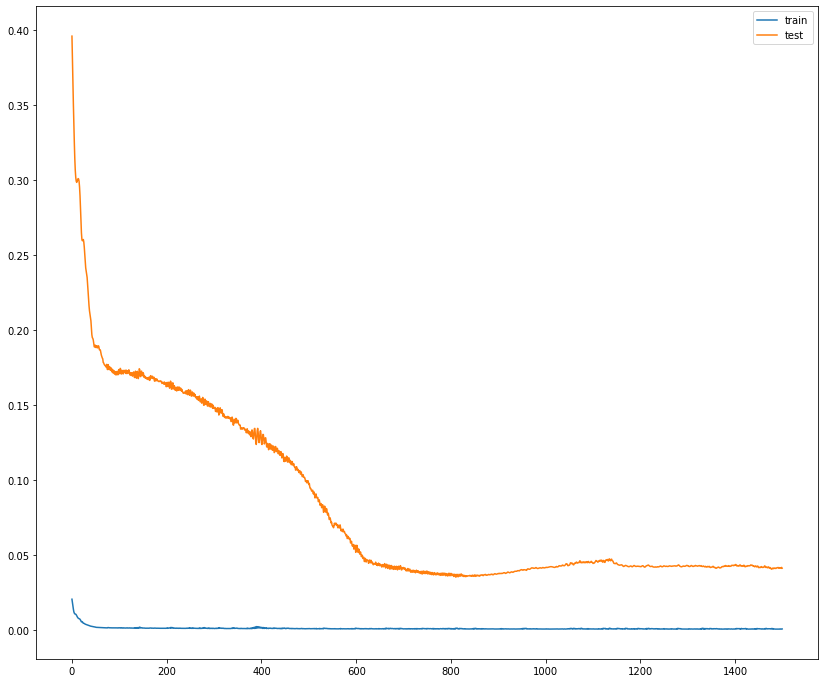

(58, 1, 23) (58,) (37, 23) (37,)


In [64]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Train and Test Shapes", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design Stacked LSTM networks/Bi-directional LSTM networks
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=1500, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [65]:
print(split_factor)
print(daterange[split_factor+1])

58
2020-04-29T00:00:00.000000000


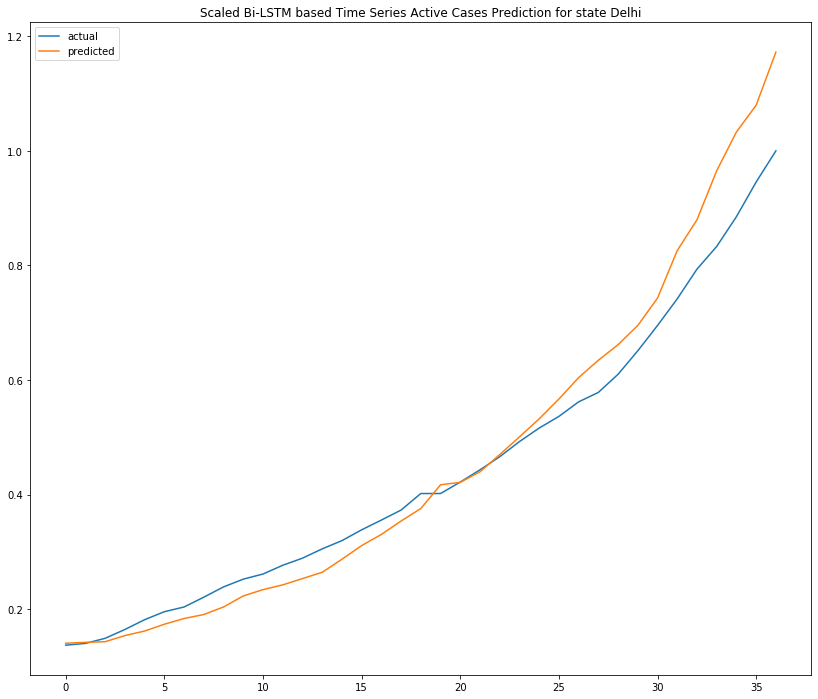

Test RMSE: 0.059
Test RMSE: 1467.873


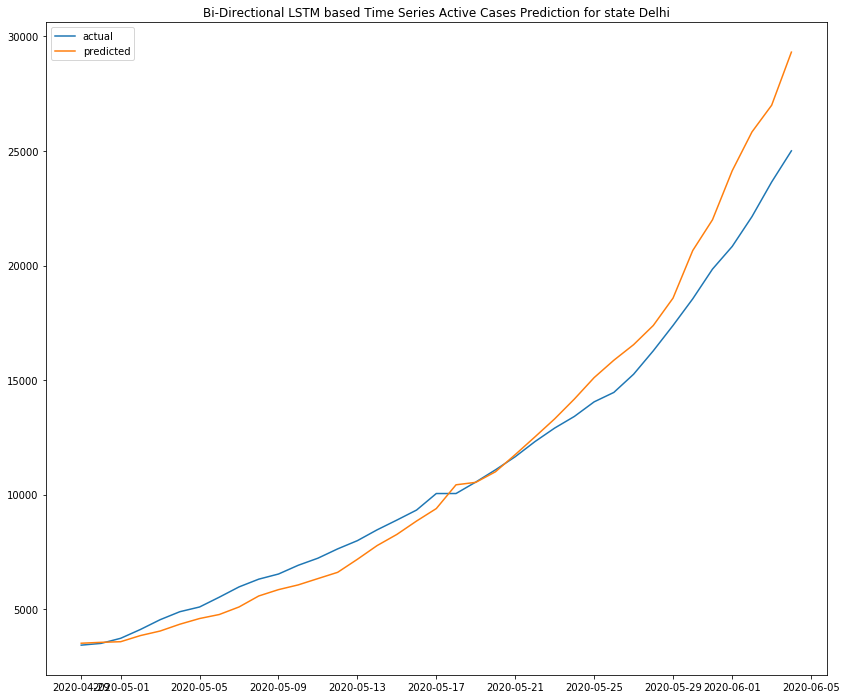

In [66]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled Bi-LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)

inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('Bi-Directional LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# Stacked - LSTM based Prediction for Delhi with all features

No of features 22
Training and Test Shapes (58, 1, 23) (58,) (37, 1, 23) (37,)
Epoch 1/1500
1/1 - 1s - loss: 0.0404 - val_loss: 0.4583
Epoch 2/1500
1/1 - 0s - loss: 0.0361 - val_loss: 0.4455
Epoch 3/1500
1/1 - 0s - loss: 0.0327 - val_loss: 0.4337
Epoch 4/1500
1/1 - 0s - loss: 0.0296 - val_loss: 0.4227
Epoch 5/1500
1/1 - 0s - loss: 0.0265 - val_loss: 0.4121
Epoch 6/1500
1/1 - 0s - loss: 0.0235 - val_loss: 0.4020
Epoch 7/1500
1/1 - 0s - loss: 0.0210 - val_loss: 0.3926
Epoch 8/1500
1/1 - 0s - loss: 0.0190 - val_loss: 0.3839
Epoch 9/1500
1/1 - 0s - loss: 0.0171 - val_loss: 0.3760
Epoch 10/1500
1/1 - 0s - loss: 0.0151 - val_loss: 0.3684
Epoch 11/1500
1/1 - 0s - loss: 0.0129 - val_loss: 0.3612
Epoch 12/1500
1/1 - 0s - loss: 0.0111 - val_loss: 0.3546
Epoch 13/1500
1/1 - 0s - loss: 0.0097 - val_loss: 0.3485
Epoch 14/1500
1/1 - 0s - loss: 0.0105 - val_loss: 0.3418
Epoch 15/1500
1/1 - 0s - loss: 0.0113 - val_loss: 0.3350
Epoch 16/1500
1/1 - 0s - loss: 0.0118 - val_loss: 0.3287
Epoch 17/1500
1/1 

Epoch 143/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1826
Epoch 144/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1840
Epoch 145/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1876
Epoch 146/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1868
Epoch 147/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1837
Epoch 148/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1833
Epoch 149/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1867
Epoch 150/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1873
Epoch 151/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1847
Epoch 152/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1831
Epoch 153/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1857
Epoch 154/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1866
Epoch 155/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1853
Epoch 156/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1832
Epoch 157/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1850
Epoch 158/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1852
Epoch 159/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1849
Epoch 160/1500

1/1 - 0s - loss: 0.0013 - val_loss: 0.1728
Epoch 285/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1744
Epoch 286/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1759
Epoch 287/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1743
Epoch 288/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1731
Epoch 289/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1738
Epoch 290/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1745
Epoch 291/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1724
Epoch 292/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1721
Epoch 293/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1743
Epoch 294/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1741
Epoch 295/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1719
Epoch 296/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1716
Epoch 297/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1728
Epoch 298/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1711
Epoch 299/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1724
Epoch 300/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1737
Epoch 301/1500
1/1 - 0s - los

Epoch 426/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1610
Epoch 427/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1618
Epoch 428/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1622
Epoch 429/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1591
Epoch 430/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1575
Epoch 431/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1582
Epoch 432/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1600
Epoch 433/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1610
Epoch 434/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1585
Epoch 435/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1591
Epoch 436/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1608
Epoch 437/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1581
Epoch 438/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1574
Epoch 439/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1598
Epoch 440/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1611
Epoch 441/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1616
Epoch 442/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1615
Epoch 443/1500

1/1 - 0s - loss: 0.0010 - val_loss: 0.1442
Epoch 568/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1444
Epoch 569/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1451
Epoch 570/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1442
Epoch 571/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1452
Epoch 572/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1458
Epoch 573/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1455
Epoch 574/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1452
Epoch 575/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1458
Epoch 576/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1452
Epoch 577/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1457
Epoch 578/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1462
Epoch 579/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1445
Epoch 580/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1426
Epoch 581/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1431
Epoch 582/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1422
Epoch 583/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1418
Epoch 584/1500
1/1 - 0s - los

1/1 - 0s - loss: 9.5343e-04 - val_loss: 0.1321
Epoch 708/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1338
Epoch 709/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1324
Epoch 710/1500
1/1 - 0s - loss: 9.4373e-04 - val_loss: 0.1325
Epoch 711/1500
1/1 - 0s - loss: 9.5961e-04 - val_loss: 0.1334
Epoch 712/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1323
Epoch 713/1500
1/1 - 0s - loss: 9.6622e-04 - val_loss: 0.1306
Epoch 714/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1328
Epoch 715/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1308
Epoch 716/1500
1/1 - 0s - loss: 9.9872e-04 - val_loss: 0.1316
Epoch 717/1500
1/1 - 0s - loss: 9.5033e-04 - val_loss: 0.1321
Epoch 718/1500
1/1 - 0s - loss: 9.6597e-04 - val_loss: 0.1315
Epoch 719/1500
1/1 - 0s - loss: 9.4163e-04 - val_loss: 0.1306
Epoch 720/1500
1/1 - 0s - loss: 9.7609e-04 - val_loss: 0.1322
Epoch 721/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1306
Epoch 722/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1330
Epoch 723/1500
1/1 - 0s - loss: 0.0010 - val_loss: 

Epoch 845/1500
1/1 - 0s - loss: 9.5216e-04 - val_loss: 0.1214
Epoch 846/1500
1/1 - 0s - loss: 9.5204e-04 - val_loss: 0.1242
Epoch 847/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1218
Epoch 848/1500
1/1 - 0s - loss: 8.9205e-04 - val_loss: 0.1195
Epoch 849/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1214
Epoch 850/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1268
Epoch 851/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1267
Epoch 852/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1226
Epoch 853/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1232
Epoch 854/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1277
Epoch 855/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1276
Epoch 856/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1227
Epoch 857/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.1223
Epoch 858/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1259
Epoch 859/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1302
Epoch 860/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.1298
Epoch 861/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1280
Ep

1/1 - 0s - loss: 0.0010 - val_loss: 0.1208
Epoch 985/1500
1/1 - 0s - loss: 9.6468e-04 - val_loss: 0.1214
Epoch 986/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1198
Epoch 987/1500
1/1 - 0s - loss: 9.8239e-04 - val_loss: 0.1192
Epoch 988/1500
1/1 - 0s - loss: 9.0765e-04 - val_loss: 0.1186
Epoch 989/1500
1/1 - 0s - loss: 8.9719e-04 - val_loss: 0.1172
Epoch 990/1500
1/1 - 0s - loss: 9.8472e-04 - val_loss: 0.1185
Epoch 991/1500
1/1 - 0s - loss: 8.8558e-04 - val_loss: 0.1194
Epoch 992/1500
1/1 - 0s - loss: 9.0641e-04 - val_loss: 0.1194
Epoch 993/1500
1/1 - 0s - loss: 9.1124e-04 - val_loss: 0.1191
Epoch 994/1500
1/1 - 0s - loss: 9.5475e-04 - val_loss: 0.1198
Epoch 995/1500
1/1 - 0s - loss: 9.3217e-04 - val_loss: 0.1190
Epoch 996/1500
1/1 - 0s - loss: 8.9778e-04 - val_loss: 0.1175
Epoch 997/1500
1/1 - 0s - loss: 9.0117e-04 - val_loss: 0.1175
Epoch 998/1500
1/1 - 0s - loss: 9.1715e-04 - val_loss: 0.1173
Epoch 999/1500
1/1 - 0s - loss: 9.2800e-04 - val_loss: 0.1201
Epoch 1000/1500
1/1 - 0s - loss

1/1 - 0s - loss: 0.0011 - val_loss: 0.1107
Epoch 1119/1500
1/1 - 0s - loss: 9.3640e-04 - val_loss: 0.1141
Epoch 1120/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1131
Epoch 1121/1500
1/1 - 0s - loss: 9.7232e-04 - val_loss: 0.1089
Epoch 1122/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.1087
Epoch 1123/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1121
Epoch 1124/1500
1/1 - 0s - loss: 9.4577e-04 - val_loss: 0.1170
Epoch 1125/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.1174
Epoch 1126/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.1138
Epoch 1127/1500
1/1 - 0s - loss: 9.5763e-04 - val_loss: 0.1108
Epoch 1128/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.1117
Epoch 1129/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1161
Epoch 1130/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1173
Epoch 1131/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.1144
Epoch 1132/1500
1/1 - 0s - loss: 9.0702e-04 - val_loss: 0.1114
Epoch 1133/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1119
Epoch 1134/1500
1/1 - 0s - loss: 0.0011 - val_loss: 

Epoch 1251/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1055
Epoch 1252/1500
1/1 - 0s - loss: 9.6315e-04 - val_loss: 0.1040
Epoch 1253/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1059
Epoch 1254/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1089
Epoch 1255/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.1081
Epoch 1256/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1044
Epoch 1257/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1041
Epoch 1258/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1068
Epoch 1259/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1069
Epoch 1260/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1049
Epoch 1261/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1061
Epoch 1262/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1085
Epoch 1263/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.1073
Epoch 1264/1500
1/1 - 0s - loss: 9.4576e-04 - val_loss: 0.1042
Epoch 1265/1500
1/1 - 0s - loss: 0.0010 - val_loss: 0.1045
Epoch 1266/1500
1/1 - 0s - loss: 8.4640e-04 - val_loss: 0.1047
Epoch 1267/1500
1/1 - 0s - loss: 0.0011 - va

1/1 - 0s - loss: 8.6663e-04 - val_loss: 0.1009
Epoch 1385/1500
1/1 - 0s - loss: 8.6585e-04 - val_loss: 0.1004
Epoch 1386/1500
1/1 - 0s - loss: 8.5003e-04 - val_loss: 0.1008
Epoch 1387/1500
1/1 - 0s - loss: 9.2613e-04 - val_loss: 0.0988
Epoch 1388/1500
1/1 - 0s - loss: 8.3635e-04 - val_loss: 0.0977
Epoch 1389/1500
1/1 - 0s - loss: 8.9774e-04 - val_loss: 0.0990
Epoch 1390/1500
1/1 - 0s - loss: 8.8341e-04 - val_loss: 0.0985
Epoch 1391/1500
1/1 - 0s - loss: 8.4184e-04 - val_loss: 0.0992
Epoch 1392/1500
1/1 - 0s - loss: 8.2833e-04 - val_loss: 0.1007
Epoch 1393/1500
1/1 - 0s - loss: 8.6013e-04 - val_loss: 0.1002
Epoch 1394/1500
1/1 - 0s - loss: 8.4328e-04 - val_loss: 0.0998
Epoch 1395/1500
1/1 - 0s - loss: 8.6286e-04 - val_loss: 0.1009
Epoch 1396/1500
1/1 - 0s - loss: 9.1691e-04 - val_loss: 0.1004
Epoch 1397/1500
1/1 - 0s - loss: 8.3742e-04 - val_loss: 0.1001
Epoch 1398/1500
1/1 - 0s - loss: 8.4227e-04 - val_loss: 0.0998
Epoch 1399/1500
1/1 - 0s - loss: 8.2737e-04 - val_loss: 0.0991
Epoch 14

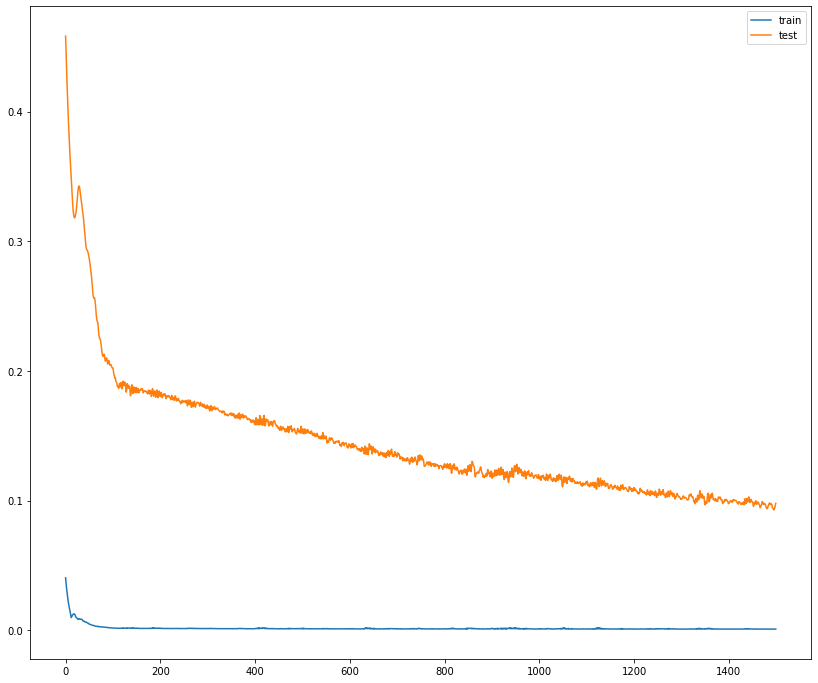

(58, 1, 23) (58,) (37, 23) (37,)


In [67]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]


dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

#no_features = 22
no_features = np.shape(dataset)[1]-1
print("No of features", no_features)
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Training and Test Shapes", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design Stacked LSTM networks
model = Sequential()

#model.add(Bidirectional(LSTM(units=50, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=1500, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

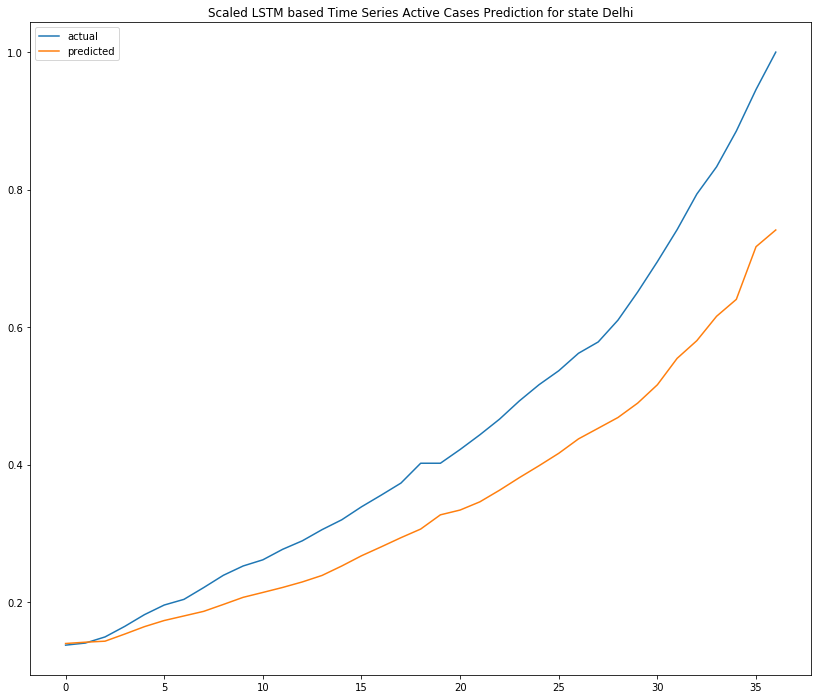

Test RMSE: 0.121
Test RMSE: 3024.363


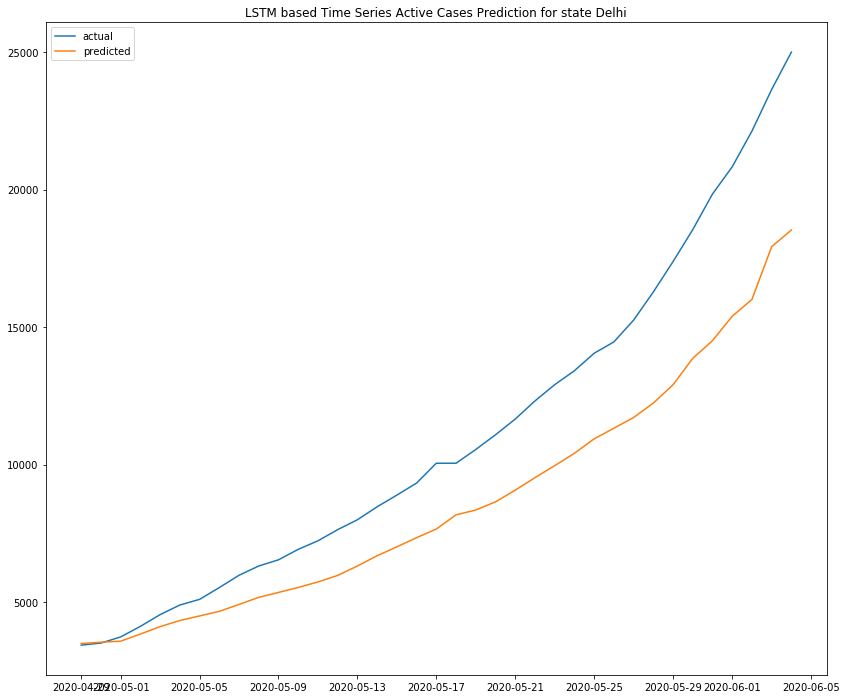

In [68]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# CNN based Prediction for Delhi with all features (with timesteps =2)

(58, 24) 58
(57, 2, 23) (57,)
(37, 24) 37
(36, 2, 23) (36,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 2, 64)             1536      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 4,837
Trainable params: 4,837
Non-trainable params: 0
_________________________________________________________________
Train on 57 samples, validate on 36 samples
Epoch 1/1500


Epoch 114/1500
57/57 - 0s - loss: 3.6421e-06 - val_loss: 0.0865
Epoch 115/1500
57/57 - 0s - loss: 3.6220e-06 - val_loss: 0.0865
Epoch 116/1500
57/57 - 0s - loss: 3.6030e-06 - val_loss: 0.0866
Epoch 117/1500
57/57 - 0s - loss: 3.5903e-06 - val_loss: 0.0866
Epoch 118/1500
57/57 - 0s - loss: 3.5761e-06 - val_loss: 0.0866
Epoch 119/1500
57/57 - 0s - loss: 3.5653e-06 - val_loss: 0.0866
Epoch 120/1500
57/57 - 0s - loss: 3.5469e-06 - val_loss: 0.0866
Epoch 121/1500
57/57 - 0s - loss: 3.5405e-06 - val_loss: 0.0866
Epoch 122/1500
57/57 - 0s - loss: 3.5284e-06 - val_loss: 0.0867
Epoch 123/1500
57/57 - 0s - loss: 3.5151e-06 - val_loss: 0.0867
Epoch 124/1500
57/57 - 0s - loss: 3.5002e-06 - val_loss: 0.0867
Epoch 125/1500
57/57 - 0s - loss: 3.4865e-06 - val_loss: 0.0867
Epoch 126/1500
57/57 - 0s - loss: 3.4715e-06 - val_loss: 0.0867
Epoch 127/1500
57/57 - 0s - loss: 3.4566e-06 - val_loss: 0.0867
Epoch 128/1500
57/57 - 0s - loss: 3.4467e-06 - val_loss: 0.0867
Epoch 129/1500
57/57 - 0s - loss: 3.4374

57/57 - 0s - loss: 1.8728e-05 - val_loss: 0.0790
Epoch 243/1500
57/57 - 0s - loss: 2.4920e-05 - val_loss: 0.0776
Epoch 244/1500
57/57 - 0s - loss: 2.9646e-05 - val_loss: 0.0788
Epoch 245/1500
57/57 - 0s - loss: 3.5398e-05 - val_loss: 0.0779
Epoch 246/1500
57/57 - 0s - loss: 3.4278e-05 - val_loss: 0.0785
Epoch 247/1500
57/57 - 0s - loss: 3.0852e-05 - val_loss: 0.0787
Epoch 248/1500
57/57 - 0s - loss: 2.0571e-05 - val_loss: 0.0781
Epoch 249/1500
57/57 - 0s - loss: 1.0905e-05 - val_loss: 0.0798
Epoch 250/1500
57/57 - 0s - loss: 3.7277e-06 - val_loss: 0.0782
Epoch 251/1500
57/57 - 0s - loss: 2.1918e-06 - val_loss: 0.0799
Epoch 252/1500
57/57 - 0s - loss: 4.1002e-06 - val_loss: 0.0784
Epoch 253/1500
57/57 - 0s - loss: 7.0853e-06 - val_loss: 0.0791
Epoch 254/1500
57/57 - 0s - loss: 9.4429e-06 - val_loss: 0.0781
Epoch 255/1500
57/57 - 0s - loss: 9.7413e-06 - val_loss: 0.0781
Epoch 256/1500
57/57 - 0s - loss: 9.2189e-06 - val_loss: 0.0778
Epoch 257/1500
57/57 - 0s - loss: 7.0809e-06 - val_loss

Epoch 371/1500
57/57 - 0s - loss: 9.0667e-07 - val_loss: 0.0599
Epoch 372/1500
57/57 - 0s - loss: 1.2929e-06 - val_loss: 0.0592
Epoch 373/1500
57/57 - 0s - loss: 1.9010e-06 - val_loss: 0.0595
Epoch 374/1500
57/57 - 0s - loss: 2.5613e-06 - val_loss: 0.0589
Epoch 375/1500
57/57 - 0s - loss: 3.1467e-06 - val_loss: 0.0592
Epoch 376/1500
57/57 - 0s - loss: 3.7182e-06 - val_loss: 0.0587
Epoch 377/1500
57/57 - 0s - loss: 4.3176e-06 - val_loss: 0.0590
Epoch 378/1500
57/57 - 0s - loss: 5.1126e-06 - val_loss: 0.0584
Epoch 379/1500
57/57 - 0s - loss: 5.9688e-06 - val_loss: 0.0588
Epoch 380/1500
57/57 - 0s - loss: 7.3130e-06 - val_loss: 0.0581
Epoch 381/1500
57/57 - 0s - loss: 8.6470e-06 - val_loss: 0.0586
Epoch 382/1500
57/57 - 0s - loss: 1.0188e-05 - val_loss: 0.0581
Epoch 383/1500
57/57 - 0s - loss: 1.1393e-05 - val_loss: 0.0586
Epoch 384/1500
57/57 - 0s - loss: 1.2534e-05 - val_loss: 0.0581
Epoch 385/1500
57/57 - 0s - loss: 1.3612e-05 - val_loss: 0.0585
Epoch 386/1500
57/57 - 0s - loss: 1.3985

57/57 - 0s - loss: 1.2651e-06 - val_loss: 0.0633
Epoch 500/1500
57/57 - 0s - loss: 1.9350e-06 - val_loss: 0.0632
Epoch 501/1500
57/57 - 0s - loss: 2.1396e-06 - val_loss: 0.0635
Epoch 502/1500
57/57 - 0s - loss: 1.6833e-06 - val_loss: 0.0639
Epoch 503/1500
57/57 - 0s - loss: 1.0727e-06 - val_loss: 0.0637
Epoch 504/1500
57/57 - 0s - loss: 8.6157e-07 - val_loss: 0.0643
Epoch 505/1500
57/57 - 0s - loss: 9.9106e-07 - val_loss: 0.0642
Epoch 506/1500
57/57 - 0s - loss: 1.1378e-06 - val_loss: 0.0646
Epoch 507/1500
57/57 - 0s - loss: 1.1090e-06 - val_loss: 0.0647
Epoch 508/1500
57/57 - 0s - loss: 9.3311e-07 - val_loss: 0.0647
Epoch 509/1500
57/57 - 0s - loss: 7.5833e-07 - val_loss: 0.0651
Epoch 510/1500
57/57 - 0s - loss: 6.8539e-07 - val_loss: 0.0650
Epoch 511/1500
57/57 - 0s - loss: 6.9746e-07 - val_loss: 0.0653
Epoch 512/1500
57/57 - 0s - loss: 7.3485e-07 - val_loss: 0.0653
Epoch 513/1500
57/57 - 0s - loss: 7.5385e-07 - val_loss: 0.0654
Epoch 514/1500
57/57 - 0s - loss: 7.2451e-07 - val_loss

Epoch 628/1500
57/57 - 0s - loss: 1.2976e-05 - val_loss: 0.0637
Epoch 629/1500
57/57 - 0s - loss: 2.1297e-05 - val_loss: 0.0618
Epoch 630/1500
57/57 - 0s - loss: 3.4345e-05 - val_loss: 0.0637
Epoch 631/1500
57/57 - 0s - loss: 5.3093e-05 - val_loss: 0.0612
Epoch 632/1500
57/57 - 0s - loss: 7.1930e-05 - val_loss: 0.0629
Epoch 633/1500
57/57 - 0s - loss: 8.8997e-05 - val_loss: 0.0609
Epoch 634/1500
57/57 - 0s - loss: 8.8934e-05 - val_loss: 0.0611
Epoch 635/1500
57/57 - 0s - loss: 6.6459e-05 - val_loss: 0.0622
Epoch 636/1500
57/57 - 0s - loss: 3.2079e-05 - val_loss: 0.0598
Epoch 637/1500
57/57 - 0s - loss: 7.2630e-06 - val_loss: 0.0634
Epoch 638/1500
57/57 - 0s - loss: 2.6149e-06 - val_loss: 0.0606
Epoch 639/1500
57/57 - 0s - loss: 1.1004e-05 - val_loss: 0.0631
Epoch 640/1500
57/57 - 0s - loss: 2.0713e-05 - val_loss: 0.0627
Epoch 641/1500
57/57 - 0s - loss: 1.9360e-05 - val_loss: 0.0631
Epoch 642/1500
57/57 - 0s - loss: 1.0308e-05 - val_loss: 0.0645
Epoch 643/1500
57/57 - 0s - loss: 2.7659

Epoch 757/1500
57/57 - 0s - loss: 3.2833e-07 - val_loss: 0.0594
Epoch 758/1500
57/57 - 0s - loss: 3.3943e-07 - val_loss: 0.0592
Epoch 759/1500
57/57 - 0s - loss: 3.6710e-07 - val_loss: 0.0593
Epoch 760/1500
57/57 - 0s - loss: 4.0076e-07 - val_loss: 0.0591
Epoch 761/1500
57/57 - 0s - loss: 4.7202e-07 - val_loss: 0.0591
Epoch 762/1500
57/57 - 0s - loss: 5.6608e-07 - val_loss: 0.0589
Epoch 763/1500
57/57 - 0s - loss: 7.3431e-07 - val_loss: 0.0591
Epoch 764/1500
57/57 - 0s - loss: 9.7679e-07 - val_loss: 0.0587
Epoch 765/1500
57/57 - 0s - loss: 1.3908e-06 - val_loss: 0.0590
Epoch 766/1500
57/57 - 0s - loss: 2.0201e-06 - val_loss: 0.0584
Epoch 767/1500
57/57 - 0s - loss: 3.0861e-06 - val_loss: 0.0589
Epoch 768/1500
57/57 - 0s - loss: 4.7288e-06 - val_loss: 0.0581
Epoch 769/1500
57/57 - 0s - loss: 7.2031e-06 - val_loss: 0.0588
Epoch 770/1500
57/57 - 0s - loss: 1.0995e-05 - val_loss: 0.0575
Epoch 771/1500
57/57 - 0s - loss: 1.6327e-05 - val_loss: 0.0586
Epoch 772/1500
57/57 - 0s - loss: 2.3715

Epoch 886/1500
57/57 - 0s - loss: 5.5428e-07 - val_loss: 0.0557
Epoch 887/1500
57/57 - 0s - loss: 4.9497e-07 - val_loss: 0.0556
Epoch 888/1500
57/57 - 0s - loss: 4.2807e-07 - val_loss: 0.0557
Epoch 889/1500
57/57 - 0s - loss: 4.0086e-07 - val_loss: 0.0556
Epoch 890/1500
57/57 - 0s - loss: 4.0455e-07 - val_loss: 0.0557
Epoch 891/1500
57/57 - 0s - loss: 4.2142e-07 - val_loss: 0.0556
Epoch 892/1500
57/57 - 0s - loss: 4.3239e-07 - val_loss: 0.0556
Epoch 893/1500
57/57 - 0s - loss: 4.2181e-07 - val_loss: 0.0556
Epoch 894/1500
57/57 - 0s - loss: 4.0547e-07 - val_loss: 0.0555
Epoch 895/1500
57/57 - 0s - loss: 3.8843e-07 - val_loss: 0.0556
Epoch 896/1500
57/57 - 0s - loss: 3.8009e-07 - val_loss: 0.0555
Epoch 897/1500
57/57 - 0s - loss: 3.7745e-07 - val_loss: 0.0556
Epoch 898/1500
57/57 - 0s - loss: 3.7842e-07 - val_loss: 0.0555
Epoch 899/1500
57/57 - 0s - loss: 3.7955e-07 - val_loss: 0.0555
Epoch 900/1500
57/57 - 0s - loss: 3.7694e-07 - val_loss: 0.0555
Epoch 901/1500
57/57 - 0s - loss: 3.7412

Epoch 1014/1500
57/57 - 0s - loss: 3.0575e-07 - val_loss: 0.0539
Epoch 1015/1500
57/57 - 0s - loss: 3.0385e-07 - val_loss: 0.0539
Epoch 1016/1500
57/57 - 0s - loss: 3.0239e-07 - val_loss: 0.0539
Epoch 1017/1500
57/57 - 0s - loss: 3.0087e-07 - val_loss: 0.0539
Epoch 1018/1500
57/57 - 0s - loss: 3.0025e-07 - val_loss: 0.0539
Epoch 1019/1500
57/57 - 0s - loss: 2.9883e-07 - val_loss: 0.0539
Epoch 1020/1500
57/57 - 0s - loss: 2.9825e-07 - val_loss: 0.0539
Epoch 1021/1500
57/57 - 0s - loss: 2.9635e-07 - val_loss: 0.0538
Epoch 1022/1500
57/57 - 0s - loss: 2.9563e-07 - val_loss: 0.0538
Epoch 1023/1500
57/57 - 0s - loss: 2.9384e-07 - val_loss: 0.0538
Epoch 1024/1500
57/57 - 0s - loss: 2.9370e-07 - val_loss: 0.0538
Epoch 1025/1500
57/57 - 0s - loss: 2.9232e-07 - val_loss: 0.0538
Epoch 1026/1500
57/57 - 0s - loss: 2.9278e-07 - val_loss: 0.0538
Epoch 1027/1500
57/57 - 0s - loss: 2.9215e-07 - val_loss: 0.0537
Epoch 1028/1500
57/57 - 0s - loss: 2.9315e-07 - val_loss: 0.0537
Epoch 1029/1500
57/57 - 0

57/57 - 0s - loss: 2.5454e-06 - val_loss: 0.0501
Epoch 1141/1500
57/57 - 0s - loss: 3.8755e-06 - val_loss: 0.0507
Epoch 1142/1500
57/57 - 0s - loss: 5.8334e-06 - val_loss: 0.0498
Epoch 1143/1500
57/57 - 0s - loss: 8.8181e-06 - val_loss: 0.0508
Epoch 1144/1500
57/57 - 0s - loss: 1.3531e-05 - val_loss: 0.0494
Epoch 1145/1500
57/57 - 0s - loss: 2.0081e-05 - val_loss: 0.0507
Epoch 1146/1500
57/57 - 0s - loss: 2.9423e-05 - val_loss: 0.0488
Epoch 1147/1500
57/57 - 0s - loss: 4.2473e-05 - val_loss: 0.0503
Epoch 1148/1500
57/57 - 0s - loss: 5.8282e-05 - val_loss: 0.0482
Epoch 1149/1500
57/57 - 0s - loss: 7.2085e-05 - val_loss: 0.0496
Epoch 1150/1500
57/57 - 0s - loss: 7.8499e-05 - val_loss: 0.0488
Epoch 1151/1500
57/57 - 0s - loss: 7.0323e-05 - val_loss: 0.0490
Epoch 1152/1500
57/57 - 0s - loss: 5.0600e-05 - val_loss: 0.0504
Epoch 1153/1500
57/57 - 0s - loss: 2.4151e-05 - val_loss: 0.0487
Epoch 1154/1500
57/57 - 0s - loss: 5.2052e-06 - val_loss: 0.0516
Epoch 1155/1500
57/57 - 0s - loss: 8.8766

Epoch 1267/1500
57/57 - 0s - loss: 2.0409e-06 - val_loss: 0.0480
Epoch 1268/1500
57/57 - 0s - loss: 2.0956e-06 - val_loss: 0.0482
Epoch 1269/1500
57/57 - 0s - loss: 1.6167e-06 - val_loss: 0.0484
Epoch 1270/1500
57/57 - 0s - loss: 1.0084e-06 - val_loss: 0.0480
Epoch 1271/1500
57/57 - 0s - loss: 5.0077e-07 - val_loss: 0.0483
Epoch 1272/1500
57/57 - 0s - loss: 2.9793e-07 - val_loss: 0.0478
Epoch 1273/1500
57/57 - 0s - loss: 3.2896e-07 - val_loss: 0.0481
Epoch 1274/1500
57/57 - 0s - loss: 4.7431e-07 - val_loss: 0.0478
Epoch 1275/1500
57/57 - 0s - loss: 6.1295e-07 - val_loss: 0.0479
Epoch 1276/1500
57/57 - 0s - loss: 6.4377e-07 - val_loss: 0.0478
Epoch 1277/1500
57/57 - 0s - loss: 5.9885e-07 - val_loss: 0.0478
Epoch 1278/1500
57/57 - 0s - loss: 4.8411e-07 - val_loss: 0.0478
Epoch 1279/1500
57/57 - 0s - loss: 3.7871e-07 - val_loss: 0.0477
Epoch 1280/1500
57/57 - 0s - loss: 2.9648e-07 - val_loss: 0.0479
Epoch 1281/1500
57/57 - 0s - loss: 2.6695e-07 - val_loss: 0.0477
Epoch 1282/1500
57/57 - 0

57/57 - 0s - loss: 2.5150e-07 - val_loss: 0.0458
Epoch 1394/1500
57/57 - 0s - loss: 2.5041e-07 - val_loss: 0.0457
Epoch 1395/1500
57/57 - 0s - loss: 2.4896e-07 - val_loss: 0.0458
Epoch 1396/1500
57/57 - 0s - loss: 2.4834e-07 - val_loss: 0.0457
Epoch 1397/1500
57/57 - 0s - loss: 2.4784e-07 - val_loss: 0.0457
Epoch 1398/1500
57/57 - 0s - loss: 2.4728e-07 - val_loss: 0.0457
Epoch 1399/1500
57/57 - 0s - loss: 2.4694e-07 - val_loss: 0.0457
Epoch 1400/1500
57/57 - 0s - loss: 2.4599e-07 - val_loss: 0.0457
Epoch 1401/1500
57/57 - 0s - loss: 2.4567e-07 - val_loss: 0.0457
Epoch 1402/1500
57/57 - 0s - loss: 2.4449e-07 - val_loss: 0.0457
Epoch 1403/1500
57/57 - 0s - loss: 2.4395e-07 - val_loss: 0.0457
Epoch 1404/1500
57/57 - 0s - loss: 2.4277e-07 - val_loss: 0.0457
Epoch 1405/1500
57/57 - 0s - loss: 2.4217e-07 - val_loss: 0.0456
Epoch 1406/1500
57/57 - 0s - loss: 2.4132e-07 - val_loss: 0.0456
Epoch 1407/1500
57/57 - 0s - loss: 2.4069e-07 - val_loss: 0.0456
Epoch 1408/1500
57/57 - 0s - loss: 2.3994

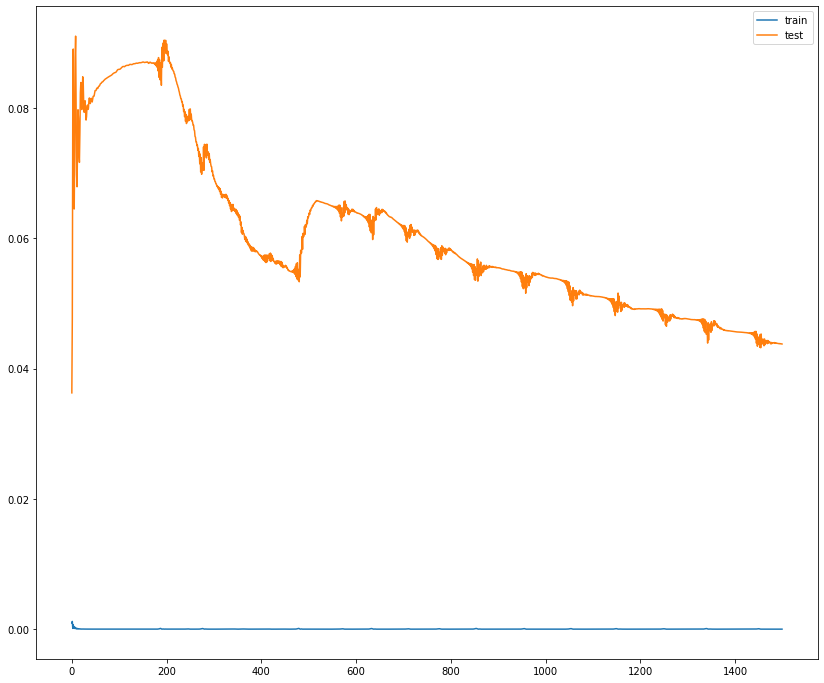

(57, 2, 23) (57,) (36, 2, 23) (36,)


In [75]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    print(sequences.shape, len(sequences))
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

n_steps = 2
# convert into input/output
train_X, train_y = split_sequences(train, n_steps)
print(train_X.shape, train_y.shape)

test_X, test_y = split_sequences(test, n_steps)
print(test_X.shape, test_y.shape)


#CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_steps, train_X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

history =model.fit(train_X, train_y, epochs=1500, batch_size=32, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

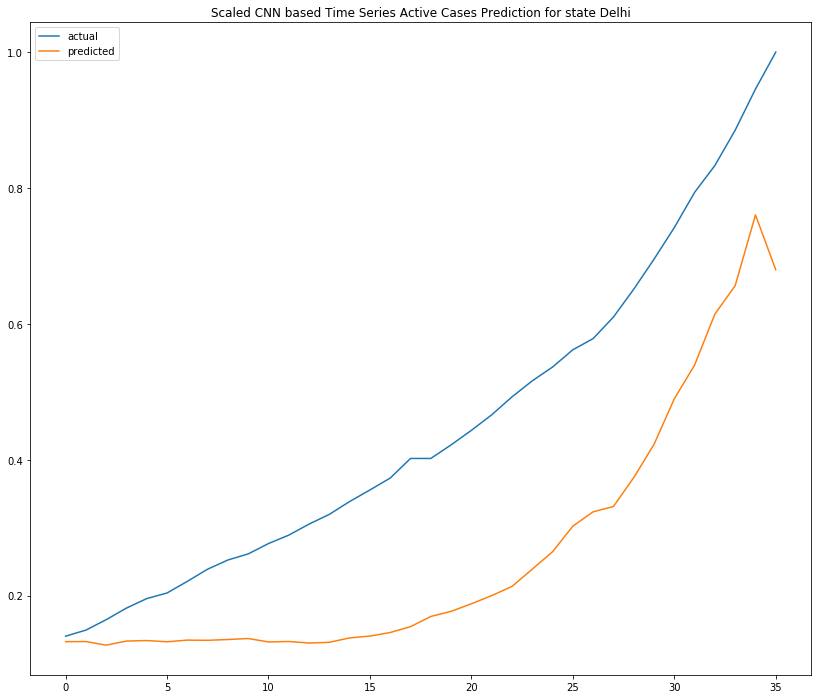

Test RMSE: 0.209 (36, 1)


In [76]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse, np.shape(y_predict))


In [77]:
def inverted_split_sequences(sequences):
    print(np.shape(sequences))
    list_X = []
    for i in range((sequences.shape[0])):
        invert_x = sequences[i, 0, :]
        list_X.append(invert_x)
    text_X = np.array(list_X)
    print(np.shape(text_X))
    return text_X
    

(36, 2, 23)
(36, 23)
Test RMSE: 5232.155


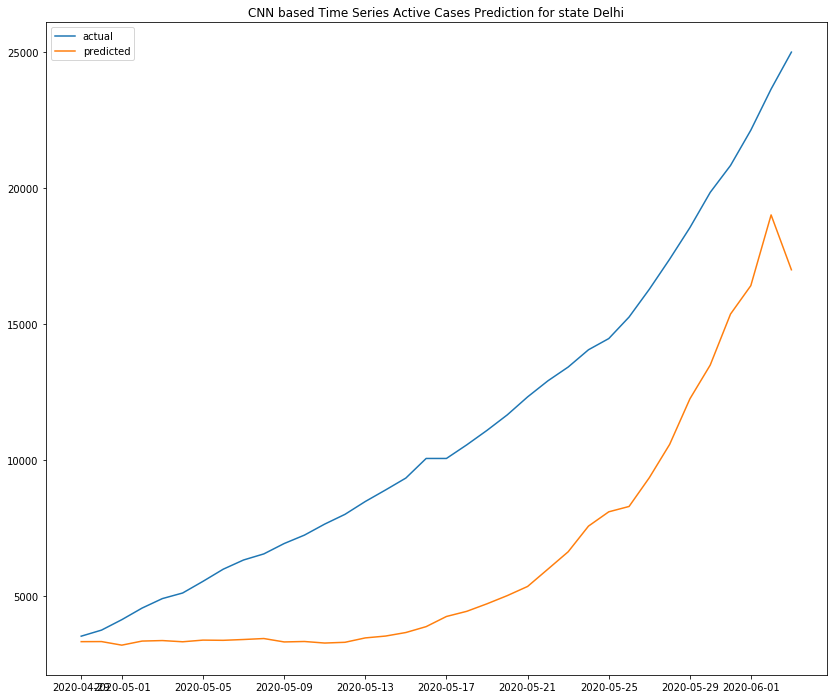

In [78]:
inv_text_X = inverted_split_sequences(test_X)
inv_y_predict = concatenate((y_predict, inv_text_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, inv_text_X[:, -(no_features):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# CNN based Prediction for Delhi with 1 feature (with timesteps =23)

Training and Test Data Shapes (58, 23) (58,) (37, 23) (37,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 22, 64)            192       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 10, 64)            8256      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               32100     
___________________________________________________________

Epoch 110/1500
58/58 - 0s - loss: 4.7948e-06 - val_loss: 0.1235
Epoch 111/1500
58/58 - 0s - loss: 4.7977e-06 - val_loss: 0.1235
Epoch 112/1500
58/58 - 0s - loss: 4.7893e-06 - val_loss: 0.1234
Epoch 113/1500
58/58 - 0s - loss: 4.7718e-06 - val_loss: 0.1234
Epoch 114/1500
58/58 - 0s - loss: 4.7635e-06 - val_loss: 0.1233
Epoch 115/1500
58/58 - 0s - loss: 4.7629e-06 - val_loss: 0.1233
Epoch 116/1500
58/58 - 0s - loss: 4.7549e-06 - val_loss: 0.1233
Epoch 117/1500
58/58 - 0s - loss: 4.7410e-06 - val_loss: 0.1234
Epoch 118/1500
58/58 - 0s - loss: 4.7335e-06 - val_loss: 0.1234
Epoch 119/1500
58/58 - 0s - loss: 4.7306e-06 - val_loss: 0.1234
Epoch 120/1500
58/58 - 0s - loss: 4.7226e-06 - val_loss: 0.1233
Epoch 121/1500
58/58 - 0s - loss: 4.7114e-06 - val_loss: 0.1232
Epoch 122/1500
58/58 - 0s - loss: 4.7051e-06 - val_loss: 0.1232
Epoch 123/1500
58/58 - 0s - loss: 4.7014e-06 - val_loss: 0.1232
Epoch 124/1500
58/58 - 0s - loss: 4.6937e-06 - val_loss: 0.1232
Epoch 125/1500
58/58 - 0s - loss: 4.6847

58/58 - 0s - loss: 4.3113e-06 - val_loss: 0.1223
Epoch 239/1500
58/58 - 0s - loss: 4.3088e-06 - val_loss: 0.1223
Epoch 240/1500
58/58 - 0s - loss: 4.3070e-06 - val_loss: 0.1223
Epoch 241/1500
58/58 - 0s - loss: 4.3049e-06 - val_loss: 0.1223
Epoch 242/1500
58/58 - 0s - loss: 4.3025e-06 - val_loss: 0.1223
Epoch 243/1500
58/58 - 0s - loss: 4.3004e-06 - val_loss: 0.1223
Epoch 244/1500
58/58 - 0s - loss: 4.2984e-06 - val_loss: 0.1223
Epoch 245/1500
58/58 - 0s - loss: 4.2964e-06 - val_loss: 0.1223
Epoch 246/1500
58/58 - 0s - loss: 4.2943e-06 - val_loss: 0.1222
Epoch 247/1500
58/58 - 0s - loss: 4.2926e-06 - val_loss: 0.1222
Epoch 248/1500
58/58 - 0s - loss: 4.2907e-06 - val_loss: 0.1222
Epoch 249/1500
58/58 - 0s - loss: 4.2885e-06 - val_loss: 0.1222
Epoch 250/1500
58/58 - 0s - loss: 4.2870e-06 - val_loss: 0.1222
Epoch 251/1500
58/58 - 0s - loss: 4.2853e-06 - val_loss: 0.1222
Epoch 252/1500
58/58 - 0s - loss: 4.2833e-06 - val_loss: 0.1222
Epoch 253/1500
58/58 - 0s - loss: 4.2812e-06 - val_loss

Epoch 367/1500
58/58 - 0s - loss: 4.1067e-06 - val_loss: 0.1214
Epoch 368/1500
58/58 - 0s - loss: 4.1051e-06 - val_loss: 0.1214
Epoch 369/1500
58/58 - 0s - loss: 4.1040e-06 - val_loss: 0.1214
Epoch 370/1500
58/58 - 0s - loss: 4.1028e-06 - val_loss: 0.1214
Epoch 371/1500
58/58 - 0s - loss: 4.1014e-06 - val_loss: 0.1214
Epoch 372/1500
58/58 - 0s - loss: 4.0998e-06 - val_loss: 0.1214
Epoch 373/1500
58/58 - 0s - loss: 4.0990e-06 - val_loss: 0.1214
Epoch 374/1500
58/58 - 0s - loss: 4.0978e-06 - val_loss: 0.1214
Epoch 375/1500
58/58 - 0s - loss: 4.0959e-06 - val_loss: 0.1214
Epoch 376/1500
58/58 - 0s - loss: 4.0947e-06 - val_loss: 0.1213
Epoch 377/1500
58/58 - 0s - loss: 4.0935e-06 - val_loss: 0.1213
Epoch 378/1500
58/58 - 0s - loss: 4.0921e-06 - val_loss: 0.1213
Epoch 379/1500
58/58 - 0s - loss: 4.0903e-06 - val_loss: 0.1213
Epoch 380/1500
58/58 - 0s - loss: 4.0883e-06 - val_loss: 0.1213
Epoch 381/1500
58/58 - 0s - loss: 4.0869e-06 - val_loss: 0.1213
Epoch 382/1500
58/58 - 0s - loss: 4.0855

58/58 - 0s - loss: 3.9135e-06 - val_loss: 0.1206
Epoch 496/1500
58/58 - 0s - loss: 3.9123e-06 - val_loss: 0.1206
Epoch 497/1500
58/58 - 0s - loss: 3.9111e-06 - val_loss: 0.1206
Epoch 498/1500
58/58 - 0s - loss: 3.9101e-06 - val_loss: 0.1206
Epoch 499/1500
58/58 - 0s - loss: 3.9090e-06 - val_loss: 0.1206
Epoch 500/1500
58/58 - 0s - loss: 3.9080e-06 - val_loss: 0.1206
Epoch 501/1500
58/58 - 0s - loss: 3.9069e-06 - val_loss: 0.1205
Epoch 502/1500
58/58 - 0s - loss: 3.9058e-06 - val_loss: 0.1205
Epoch 503/1500
58/58 - 0s - loss: 3.9045e-06 - val_loss: 0.1205
Epoch 504/1500
58/58 - 0s - loss: 3.9039e-06 - val_loss: 0.1205
Epoch 505/1500
58/58 - 0s - loss: 3.9028e-06 - val_loss: 0.1205
Epoch 506/1500
58/58 - 0s - loss: 3.9015e-06 - val_loss: 0.1205
Epoch 507/1500
58/58 - 0s - loss: 3.9007e-06 - val_loss: 0.1205
Epoch 508/1500
58/58 - 0s - loss: 3.8995e-06 - val_loss: 0.1205
Epoch 509/1500
58/58 - 0s - loss: 3.8968e-06 - val_loss: 0.1205
Epoch 510/1500
58/58 - 0s - loss: 3.8860e-06 - val_loss

Epoch 624/1500
58/58 - 0s - loss: 3.7662e-06 - val_loss: 0.1195
Epoch 625/1500
58/58 - 0s - loss: 3.7653e-06 - val_loss: 0.1195
Epoch 626/1500
58/58 - 0s - loss: 3.7644e-06 - val_loss: 0.1195
Epoch 627/1500
58/58 - 0s - loss: 3.7635e-06 - val_loss: 0.1195
Epoch 628/1500
58/58 - 0s - loss: 3.7624e-06 - val_loss: 0.1194
Epoch 629/1500
58/58 - 0s - loss: 3.7617e-06 - val_loss: 0.1194
Epoch 630/1500
58/58 - 0s - loss: 3.7608e-06 - val_loss: 0.1194
Epoch 631/1500
58/58 - 0s - loss: 3.7599e-06 - val_loss: 0.1194
Epoch 632/1500
58/58 - 0s - loss: 3.7590e-06 - val_loss: 0.1194
Epoch 633/1500
58/58 - 0s - loss: 3.7578e-06 - val_loss: 0.1194
Epoch 634/1500
58/58 - 0s - loss: 3.7571e-06 - val_loss: 0.1194
Epoch 635/1500
58/58 - 0s - loss: 3.7561e-06 - val_loss: 0.1194
Epoch 636/1500
58/58 - 0s - loss: 3.7552e-06 - val_loss: 0.1194
Epoch 637/1500
58/58 - 0s - loss: 3.7541e-06 - val_loss: 0.1194
Epoch 638/1500
58/58 - 0s - loss: 3.7533e-06 - val_loss: 0.1193
Epoch 639/1500
58/58 - 0s - loss: 3.7525

58/58 - 0s - loss: 3.6315e-06 - val_loss: 0.1182
Epoch 753/1500
58/58 - 0s - loss: 3.6302e-06 - val_loss: 0.1182
Epoch 754/1500
58/58 - 0s - loss: 3.6290e-06 - val_loss: 0.1182
Epoch 755/1500
58/58 - 0s - loss: 3.6279e-06 - val_loss: 0.1182
Epoch 756/1500
58/58 - 0s - loss: 3.6267e-06 - val_loss: 0.1182
Epoch 757/1500
58/58 - 0s - loss: 3.6255e-06 - val_loss: 0.1182
Epoch 758/1500
58/58 - 0s - loss: 3.6243e-06 - val_loss: 0.1182
Epoch 759/1500
58/58 - 0s - loss: 3.6229e-06 - val_loss: 0.1181
Epoch 760/1500
58/58 - 0s - loss: 3.6218e-06 - val_loss: 0.1181
Epoch 761/1500
58/58 - 0s - loss: 3.6208e-06 - val_loss: 0.1181
Epoch 762/1500
58/58 - 0s - loss: 3.6197e-06 - val_loss: 0.1181
Epoch 763/1500
58/58 - 0s - loss: 3.6186e-06 - val_loss: 0.1181
Epoch 764/1500
58/58 - 0s - loss: 3.6180e-06 - val_loss: 0.1181
Epoch 765/1500
58/58 - 0s - loss: 3.6166e-06 - val_loss: 0.1181
Epoch 766/1500
58/58 - 0s - loss: 3.6155e-06 - val_loss: 0.1180
Epoch 767/1500
58/58 - 0s - loss: 3.6144e-06 - val_loss

Epoch 881/1500
58/58 - 0s - loss: 3.4467e-06 - val_loss: 0.1168
Epoch 882/1500
58/58 - 0s - loss: 3.4452e-06 - val_loss: 0.1168
Epoch 883/1500
58/58 - 0s - loss: 3.4436e-06 - val_loss: 0.1168
Epoch 884/1500
58/58 - 0s - loss: 3.4422e-06 - val_loss: 0.1168
Epoch 885/1500
58/58 - 0s - loss: 3.4407e-06 - val_loss: 0.1168
Epoch 886/1500
58/58 - 0s - loss: 3.4392e-06 - val_loss: 0.1168
Epoch 887/1500
58/58 - 0s - loss: 3.4377e-06 - val_loss: 0.1167
Epoch 888/1500
58/58 - 0s - loss: 3.4363e-06 - val_loss: 0.1167
Epoch 889/1500
58/58 - 0s - loss: 3.4347e-06 - val_loss: 0.1167
Epoch 890/1500
58/58 - 0s - loss: 3.4331e-06 - val_loss: 0.1167
Epoch 891/1500
58/58 - 0s - loss: 3.4316e-06 - val_loss: 0.1167
Epoch 892/1500
58/58 - 0s - loss: 3.4302e-06 - val_loss: 0.1167
Epoch 893/1500
58/58 - 0s - loss: 3.4284e-06 - val_loss: 0.1167
Epoch 894/1500
58/58 - 0s - loss: 3.4269e-06 - val_loss: 0.1167
Epoch 895/1500
58/58 - 0s - loss: 3.4255e-06 - val_loss: 0.1166
Epoch 896/1500
58/58 - 0s - loss: 3.4238

Epoch 1009/1500
58/58 - 0s - loss: 3.2303e-06 - val_loss: 0.1151
Epoch 1010/1500
58/58 - 0s - loss: 3.2283e-06 - val_loss: 0.1151
Epoch 1011/1500
58/58 - 0s - loss: 3.2264e-06 - val_loss: 0.1151
Epoch 1012/1500
58/58 - 0s - loss: 3.2246e-06 - val_loss: 0.1151
Epoch 1013/1500
58/58 - 0s - loss: 3.2227e-06 - val_loss: 0.1151
Epoch 1014/1500
58/58 - 0s - loss: 3.2207e-06 - val_loss: 0.1151
Epoch 1015/1500
58/58 - 0s - loss: 3.2188e-06 - val_loss: 0.1150
Epoch 1016/1500
58/58 - 0s - loss: 3.2168e-06 - val_loss: 0.1150
Epoch 1017/1500
58/58 - 0s - loss: 3.2150e-06 - val_loss: 0.1150
Epoch 1018/1500
58/58 - 0s - loss: 3.2130e-06 - val_loss: 0.1150
Epoch 1019/1500
58/58 - 0s - loss: 3.2111e-06 - val_loss: 0.1150
Epoch 1020/1500
58/58 - 0s - loss: 3.2091e-06 - val_loss: 0.1150
Epoch 1021/1500
58/58 - 0s - loss: 3.2074e-06 - val_loss: 0.1150
Epoch 1022/1500
58/58 - 0s - loss: 3.2054e-06 - val_loss: 0.1149
Epoch 1023/1500
58/58 - 0s - loss: 3.2034e-06 - val_loss: 0.1149
Epoch 1024/1500
58/58 - 0

Epoch 1136/1500
58/58 - 0s - loss: 2.9458e-06 - val_loss: 0.1133
Epoch 1137/1500
58/58 - 0s - loss: 2.9431e-06 - val_loss: 0.1133
Epoch 1138/1500
58/58 - 0s - loss: 2.9404e-06 - val_loss: 0.1133
Epoch 1139/1500
58/58 - 0s - loss: 2.9376e-06 - val_loss: 0.1133
Epoch 1140/1500
58/58 - 0s - loss: 2.9350e-06 - val_loss: 0.1133
Epoch 1141/1500
58/58 - 0s - loss: 2.9322e-06 - val_loss: 0.1132
Epoch 1142/1500
58/58 - 0s - loss: 2.9294e-06 - val_loss: 0.1132
Epoch 1143/1500
58/58 - 0s - loss: 2.9268e-06 - val_loss: 0.1132
Epoch 1144/1500
58/58 - 0s - loss: 2.9241e-06 - val_loss: 0.1132
Epoch 1145/1500
58/58 - 0s - loss: 2.9214e-06 - val_loss: 0.1132
Epoch 1146/1500
58/58 - 0s - loss: 2.9187e-06 - val_loss: 0.1132
Epoch 1147/1500
58/58 - 0s - loss: 2.9161e-06 - val_loss: 0.1132
Epoch 1148/1500
58/58 - 0s - loss: 2.9132e-06 - val_loss: 0.1131
Epoch 1149/1500
58/58 - 0s - loss: 2.9104e-06 - val_loss: 0.1131
Epoch 1150/1500
58/58 - 0s - loss: 2.9074e-06 - val_loss: 0.1131
Epoch 1151/1500
58/58 - 0

58/58 - 0s - loss: 2.5309e-06 - val_loss: 0.1113
Epoch 1263/1500
58/58 - 0s - loss: 2.5270e-06 - val_loss: 0.1113
Epoch 1264/1500
58/58 - 0s - loss: 2.5234e-06 - val_loss: 0.1112
Epoch 1265/1500
58/58 - 0s - loss: 2.5193e-06 - val_loss: 0.1112
Epoch 1266/1500
58/58 - 0s - loss: 2.5153e-06 - val_loss: 0.1112
Epoch 1267/1500
58/58 - 0s - loss: 2.5113e-06 - val_loss: 0.1112
Epoch 1268/1500
58/58 - 0s - loss: 2.5074e-06 - val_loss: 0.1112
Epoch 1269/1500
58/58 - 0s - loss: 2.5034e-06 - val_loss: 0.1111
Epoch 1270/1500
58/58 - 0s - loss: 2.4991e-06 - val_loss: 0.1111
Epoch 1271/1500
58/58 - 0s - loss: 2.4952e-06 - val_loss: 0.1111
Epoch 1272/1500
58/58 - 0s - loss: 2.4909e-06 - val_loss: 0.1111
Epoch 1273/1500
58/58 - 0s - loss: 2.4866e-06 - val_loss: 0.1111
Epoch 1274/1500
58/58 - 0s - loss: 2.4825e-06 - val_loss: 0.1111
Epoch 1275/1500
58/58 - 0s - loss: 2.4788e-06 - val_loss: 0.1110
Epoch 1276/1500
58/58 - 0s - loss: 2.4742e-06 - val_loss: 0.1110
Epoch 1277/1500
58/58 - 0s - loss: 2.4696

Epoch 1389/1500
58/58 - 0s - loss: 1.9105e-06 - val_loss: 0.1072
Epoch 1390/1500
58/58 - 0s - loss: 1.9041e-06 - val_loss: 0.1072
Epoch 1391/1500
58/58 - 0s - loss: 1.8989e-06 - val_loss: 0.1072
Epoch 1392/1500
58/58 - 0s - loss: 1.8932e-06 - val_loss: 0.1071
Epoch 1393/1500
58/58 - 0s - loss: 1.8887e-06 - val_loss: 0.1071
Epoch 1394/1500
58/58 - 0s - loss: 1.8859e-06 - val_loss: 0.1069
Epoch 1395/1500
58/58 - 0s - loss: 1.8841e-06 - val_loss: 0.1070
Epoch 1396/1500
58/58 - 0s - loss: 1.8816e-06 - val_loss: 0.1068
Epoch 1397/1500
58/58 - 0s - loss: 1.8788e-06 - val_loss: 0.1070
Epoch 1398/1500
58/58 - 0s - loss: 1.8762e-06 - val_loss: 0.1066
Epoch 1399/1500
58/58 - 0s - loss: 1.8714e-06 - val_loss: 0.1068
Epoch 1400/1500
58/58 - 0s - loss: 1.8650e-06 - val_loss: 0.1065
Epoch 1401/1500
58/58 - 0s - loss: 1.8569e-06 - val_loss: 0.1066
Epoch 1402/1500
58/58 - 0s - loss: 1.8480e-06 - val_loss: 0.1064
Epoch 1403/1500
58/58 - 0s - loss: 1.8399e-06 - val_loss: 0.1064
Epoch 1404/1500
58/58 - 0

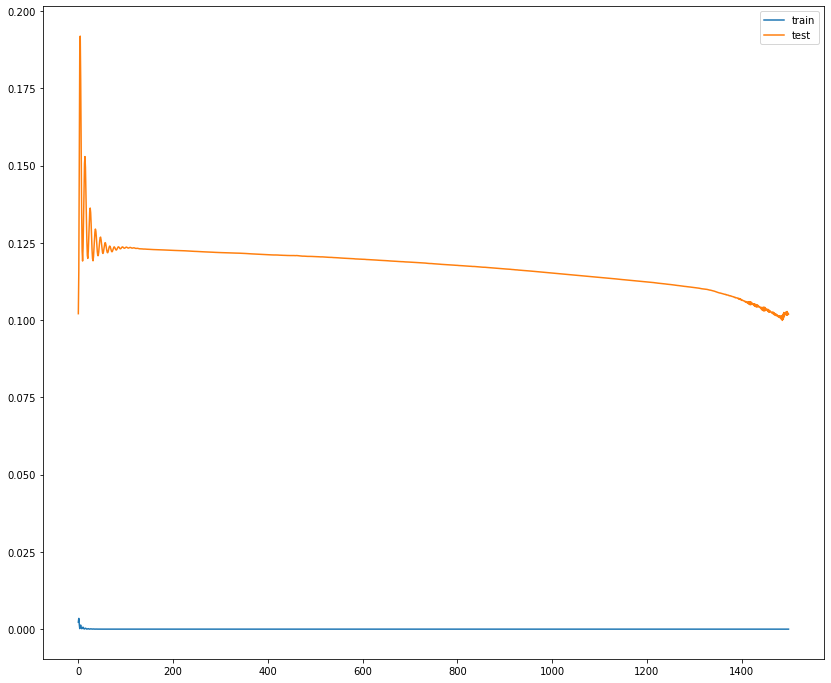

(58, 23, 1) (58,) (37, 23) (37,)


In [48]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("Training and Test Data Shapes", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


#CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

history =model.fit(train_X, train_y, epochs=1500, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

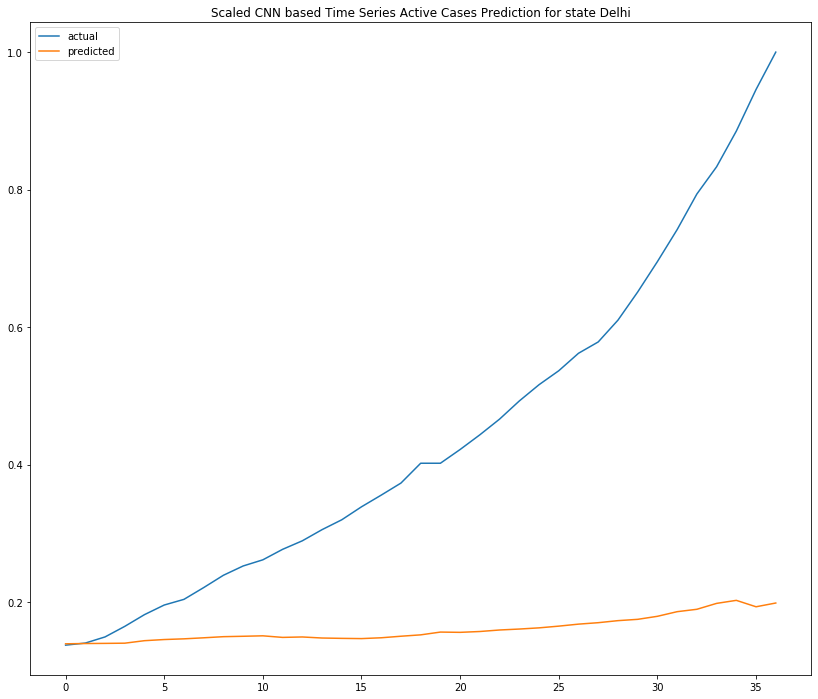

Test RMSE: 0.359
Test RMSE: 8970.185


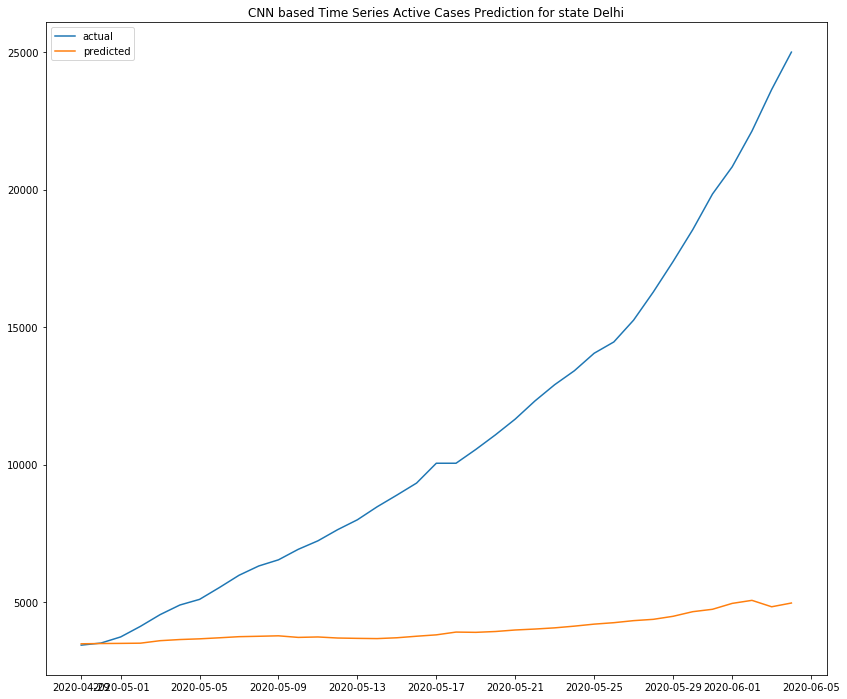

In [70]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

## LSTM + CNN based Prediction for Gujrat with all features

Gujarat (97, 32)
Train set shape (58, 1, 23, 1)
Validation set shape (19, 1, 23, 1)
Epoch 1/500
2/2 - 0s - loss: 0.0528 - val_loss: 0.5034
Epoch 2/500
2/2 - 0s - loss: 0.0340 - val_loss: 0.3791
Epoch 3/500
2/2 - 0s - loss: 0.0203 - val_loss: 0.2637
Epoch 4/500
2/2 - 0s - loss: 0.0134 - val_loss: 0.1653
Epoch 5/500
2/2 - 0s - loss: 0.0104 - val_loss: 0.0978
Epoch 6/500
2/2 - 0s - loss: 0.0095 - val_loss: 0.0693
Epoch 7/500
2/2 - 0s - loss: 0.0092 - val_loss: 0.0639
Epoch 8/500
2/2 - 0s - loss: 0.0071 - val_loss: 0.0708
Epoch 9/500
2/2 - 0s - loss: 0.0047 - val_loss: 0.0823
Epoch 10/500
2/2 - 0s - loss: 0.0033 - val_loss: 0.0901
Epoch 11/500
2/2 - 0s - loss: 0.0030 - val_loss: 0.0928
Epoch 12/500
2/2 - 0s - loss: 0.0028 - val_loss: 0.0818
Epoch 13/500
2/2 - 0s - loss: 0.0024 - val_loss: 0.0650
Epoch 14/500
2/2 - 0s - loss: 0.0020 - val_loss: 0.0452
Epoch 15/500
2/2 - 0s - loss: 0.0016 - val_loss: 0.0291
Epoch 16/500
2/2 - 0s - loss: 0.0015 - val_loss: 0.0193
Epoch 17/500
2/2 - 0s - loss:

2/2 - 0s - loss: 4.2528e-05 - val_loss: 0.0014
Epoch 138/500
2/2 - 0s - loss: 4.2024e-05 - val_loss: 0.0014
Epoch 139/500
2/2 - 0s - loss: 4.1323e-05 - val_loss: 0.0014
Epoch 140/500
2/2 - 0s - loss: 4.1087e-05 - val_loss: 0.0013
Epoch 141/500
2/2 - 0s - loss: 4.0813e-05 - val_loss: 0.0014
Epoch 142/500
2/2 - 0s - loss: 4.1715e-05 - val_loss: 0.0014
Epoch 143/500
2/2 - 0s - loss: 3.9387e-05 - val_loss: 0.0013
Epoch 144/500
2/2 - 0s - loss: 4.1422e-05 - val_loss: 0.0013
Epoch 145/500
2/2 - 0s - loss: 3.9681e-05 - val_loss: 0.0013
Epoch 146/500
2/2 - 0s - loss: 4.0467e-05 - val_loss: 0.0013
Epoch 147/500
2/2 - 0s - loss: 3.9121e-05 - val_loss: 0.0013
Epoch 148/500
2/2 - 0s - loss: 3.7693e-05 - val_loss: 0.0012
Epoch 149/500
2/2 - 0s - loss: 3.9082e-05 - val_loss: 0.0012
Epoch 150/500
2/2 - 0s - loss: 3.6878e-05 - val_loss: 0.0013
Epoch 151/500
2/2 - 0s - loss: 3.8810e-05 - val_loss: 0.0013
Epoch 152/500
2/2 - 0s - loss: 3.7467e-05 - val_loss: 0.0012
Epoch 153/500
2/2 - 0s - loss: 3.8440e

Epoch 269/500
2/2 - 0s - loss: 2.3596e-05 - val_loss: 9.1308e-04
Epoch 270/500
2/2 - 0s - loss: 2.3289e-05 - val_loss: 9.3551e-04
Epoch 271/500
2/2 - 0s - loss: 2.3082e-05 - val_loss: 8.8460e-04
Epoch 272/500
2/2 - 0s - loss: 2.2969e-05 - val_loss: 8.5496e-04
Epoch 273/500
2/2 - 0s - loss: 2.4145e-05 - val_loss: 8.8931e-04
Epoch 274/500
2/2 - 0s - loss: 2.3418e-05 - val_loss: 0.0010
Epoch 275/500
2/2 - 0s - loss: 2.4135e-05 - val_loss: 8.8968e-04
Epoch 276/500
2/2 - 0s - loss: 2.2494e-05 - val_loss: 8.2844e-04
Epoch 277/500
2/2 - 0s - loss: 2.3189e-05 - val_loss: 8.7527e-04
Epoch 278/500
2/2 - 0s - loss: 2.3730e-05 - val_loss: 9.5635e-04
Epoch 279/500
2/2 - 0s - loss: 2.3011e-05 - val_loss: 8.9080e-04
Epoch 280/500
2/2 - 0s - loss: 2.2375e-05 - val_loss: 8.2343e-04
Epoch 281/500
2/2 - 0s - loss: 2.3563e-05 - val_loss: 8.7512e-04
Epoch 282/500
2/2 - 0s - loss: 2.2172e-05 - val_loss: 9.8280e-04
Epoch 283/500
2/2 - 0s - loss: 2.3392e-05 - val_loss: 8.9985e-04
Epoch 284/500
2/2 - 0s - loss

Epoch 396/500
2/2 - 0s - loss: 1.7121e-05 - val_loss: 6.7775e-04
Epoch 397/500
2/2 - 0s - loss: 1.7717e-05 - val_loss: 7.4821e-04
Epoch 398/500
2/2 - 0s - loss: 1.6488e-05 - val_loss: 7.4670e-04
Epoch 399/500
2/2 - 0s - loss: 1.6484e-05 - val_loss: 7.2963e-04
Epoch 400/500
2/2 - 0s - loss: 1.6225e-05 - val_loss: 7.1050e-04
Epoch 401/500
2/2 - 0s - loss: 1.6553e-05 - val_loss: 7.3407e-04
Epoch 402/500
2/2 - 0s - loss: 1.6886e-05 - val_loss: 7.9864e-04
Epoch 403/500
2/2 - 0s - loss: 1.6180e-05 - val_loss: 7.3972e-04
Epoch 404/500
2/2 - 0s - loss: 1.6372e-05 - val_loss: 7.3887e-04
Epoch 405/500
2/2 - 0s - loss: 1.6288e-05 - val_loss: 7.9559e-04
Epoch 406/500
2/2 - 0s - loss: 1.6165e-05 - val_loss: 8.0506e-04
Epoch 407/500
2/2 - 0s - loss: 1.6167e-05 - val_loss: 7.4271e-04
Epoch 408/500
2/2 - 0s - loss: 1.6086e-05 - val_loss: 7.2742e-04
Epoch 409/500
2/2 - 0s - loss: 1.6438e-05 - val_loss: 7.6366e-04
Epoch 410/500
2/2 - 0s - loss: 1.6053e-05 - val_loss: 8.2577e-04
Epoch 411/500
2/2 - 0s - 

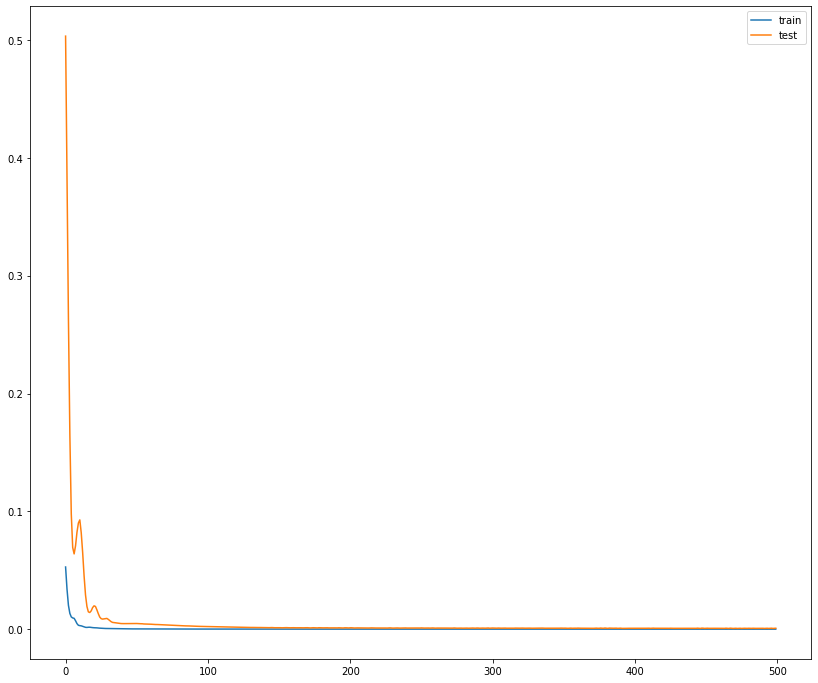

In [106]:
stateName = unique_states[10]

dataset =list_state_all[10]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]
print(stateName, np.shape(dataset))

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')


# Feature Normalization with MixMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#drop columns that need not be predicted
reframed = series_to_supervised(scaled, 1, 1)


reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#LSTM + CNN
subsequences = 1
timesteps = train_X.shape[1]
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_valid_series_sub.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=500, verbose=2)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction (LSTM + CNN)
y_predict = model.predict(X_valid_series_sub)
test_X = X_valid_series_sub.reshape((X_valid_series_sub.shape[0], X_valid_series_sub.shape[2]))

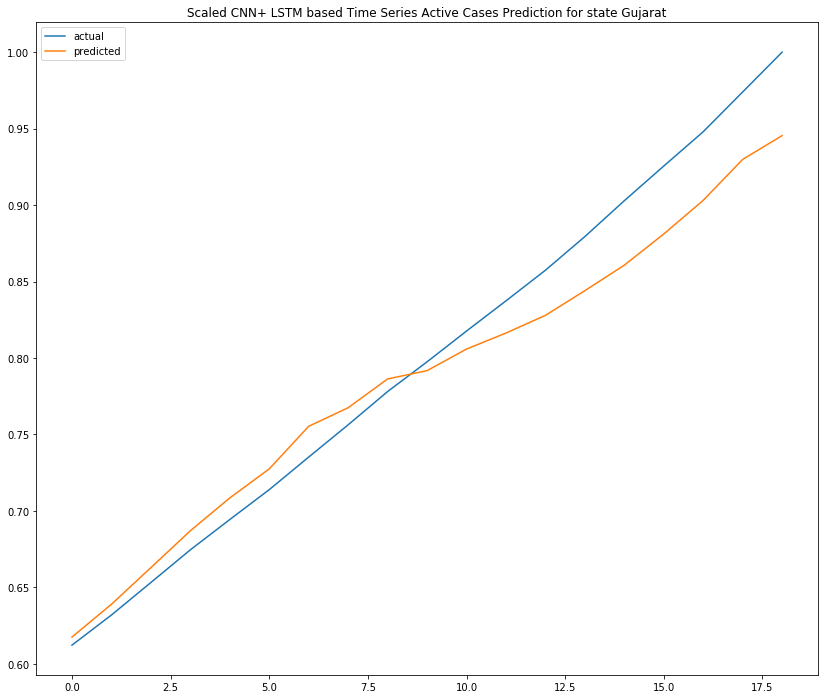

(19,) (19, 1)
Test RMSE: 0.028
Test RMSE: 517.380


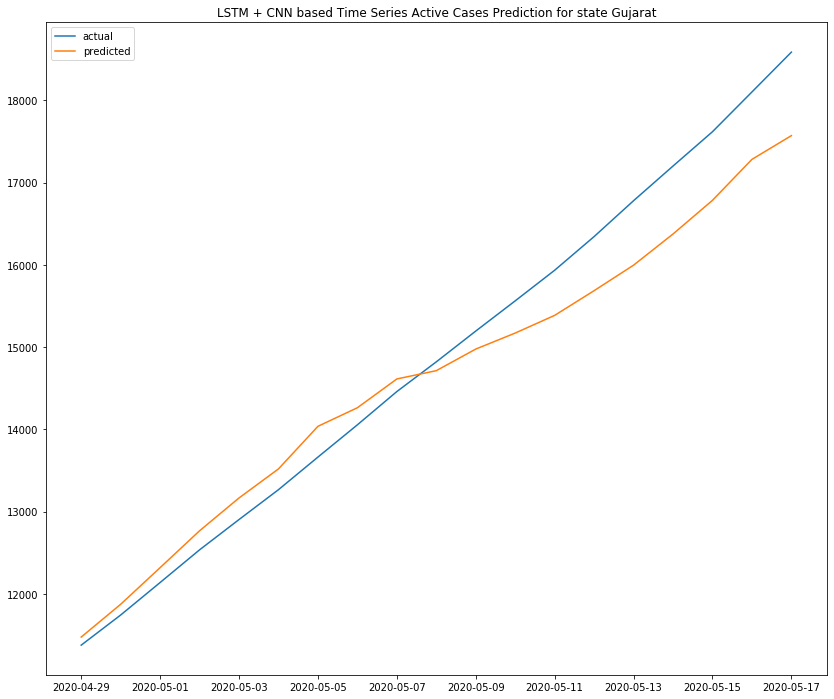

In [107]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled CNN+ LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
print(np.shape(test_y), np.shape(y_predict))
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM + CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# LSTM + CNN based Prediction for Delhi with all features

(97, 23)
(58, 23) (58,) (37, 23) (37,)
Train set shape (58, 1, 23, 1)
Validation set shape (37, 1, 23, 1)
Epoch 1/1500
2/2 - 0s - loss: 9.9519e-04 - val_loss: 0.1930
Epoch 2/1500
2/2 - 0s - loss: 3.8900e-04 - val_loss: 0.1652
Epoch 3/1500
2/2 - 0s - loss: 4.8531e-04 - val_loss: 0.1596
Epoch 4/1500
2/2 - 0s - loss: 4.6425e-04 - val_loss: 0.1645
Epoch 5/1500
2/2 - 0s - loss: 3.1554e-04 - val_loss: 0.1721
Epoch 6/1500
2/2 - 0s - loss: 2.2837e-04 - val_loss: 0.1771
Epoch 7/1500
2/2 - 0s - loss: 2.4387e-04 - val_loss: 0.1782
Epoch 8/1500
2/2 - 0s - loss: 2.6032e-04 - val_loss: 0.1746
Epoch 9/1500
2/2 - 0s - loss: 2.3099e-04 - val_loss: 0.1669
Epoch 10/1500
2/2 - 0s - loss: 1.7035e-04 - val_loss: 0.1584
Epoch 11/1500
2/2 - 0s - loss: 1.4055e-04 - val_loss: 0.1501
Epoch 12/1500
2/2 - 0s - loss: 1.3750e-04 - val_loss: 0.1438
Epoch 13/1500
2/2 - 0s - loss: 1.3191e-04 - val_loss: 0.1410
Epoch 14/1500
2/2 - 0s - loss: 1.1006e-04 - val_loss: 0.1405
Epoch 15/1500
2/2 - 0s - loss: 8.9492e-05 - val_l

2/2 - 0s - loss: 4.9861e-06 - val_loss: 0.1029
Epoch 134/1500
2/2 - 0s - loss: 5.2588e-06 - val_loss: 0.1032
Epoch 135/1500
2/2 - 0s - loss: 5.0579e-06 - val_loss: 0.1017
Epoch 136/1500
2/2 - 0s - loss: 5.1586e-06 - val_loss: 0.1019
Epoch 137/1500
2/2 - 0s - loss: 5.1863e-06 - val_loss: 0.1031
Epoch 138/1500
2/2 - 0s - loss: 4.9728e-06 - val_loss: 0.1026
Epoch 139/1500
2/2 - 0s - loss: 4.7879e-06 - val_loss: 0.1024
Epoch 140/1500
2/2 - 0s - loss: 4.8722e-06 - val_loss: 0.1029
Epoch 141/1500
2/2 - 0s - loss: 4.9500e-06 - val_loss: 0.1030
Epoch 142/1500
2/2 - 0s - loss: 4.8698e-06 - val_loss: 0.1032
Epoch 143/1500
2/2 - 0s - loss: 4.9957e-06 - val_loss: 0.1025
Epoch 144/1500
2/2 - 0s - loss: 4.7964e-06 - val_loss: 0.1029
Epoch 145/1500
2/2 - 0s - loss: 5.1474e-06 - val_loss: 0.1030
Epoch 146/1500
2/2 - 0s - loss: 4.7891e-06 - val_loss: 0.1021
Epoch 147/1500
2/2 - 0s - loss: 4.9459e-06 - val_loss: 0.1026
Epoch 148/1500
2/2 - 0s - loss: 4.7322e-06 - val_loss: 0.1032
Epoch 149/1500
2/2 - 0s

Epoch 266/1500
2/2 - 0s - loss: 4.3286e-06 - val_loss: 0.1028
Epoch 267/1500
2/2 - 0s - loss: 4.4676e-06 - val_loss: 0.1033
Epoch 268/1500
2/2 - 0s - loss: 4.2552e-06 - val_loss: 0.1039
Epoch 269/1500
2/2 - 0s - loss: 4.4641e-06 - val_loss: 0.1032
Epoch 270/1500
2/2 - 0s - loss: 4.3072e-06 - val_loss: 0.1028
Epoch 271/1500
2/2 - 0s - loss: 4.3341e-06 - val_loss: 0.1033
Epoch 272/1500
2/2 - 0s - loss: 4.3604e-06 - val_loss: 0.1032
Epoch 273/1500
2/2 - 0s - loss: 4.3535e-06 - val_loss: 0.1031
Epoch 274/1500
2/2 - 0s - loss: 4.2476e-06 - val_loss: 0.1034
Epoch 275/1500
2/2 - 0s - loss: 4.3166e-06 - val_loss: 0.1030
Epoch 276/1500
2/2 - 0s - loss: 4.3605e-06 - val_loss: 0.1030
Epoch 277/1500
2/2 - 0s - loss: 4.7200e-06 - val_loss: 0.1034
Epoch 278/1500
2/2 - 0s - loss: 4.6489e-06 - val_loss: 0.1022
Epoch 279/1500
2/2 - 0s - loss: 4.8075e-06 - val_loss: 0.1032
Epoch 280/1500
2/2 - 0s - loss: 4.4020e-06 - val_loss: 0.1025
Epoch 281/1500
2/2 - 0s - loss: 4.2724e-06 - val_loss: 0.1022
Epoch 28

2/2 - 0s - loss: 4.0072e-06 - val_loss: 0.0999
Epoch 399/1500
2/2 - 0s - loss: 4.1640e-06 - val_loss: 0.0992
Epoch 400/1500
2/2 - 0s - loss: 3.9901e-06 - val_loss: 0.0991
Epoch 401/1500
2/2 - 0s - loss: 4.0458e-06 - val_loss: 0.0991
Epoch 402/1500
2/2 - 0s - loss: 3.9871e-06 - val_loss: 0.0988
Epoch 403/1500
2/2 - 0s - loss: 4.0659e-06 - val_loss: 0.0991
Epoch 404/1500
2/2 - 0s - loss: 3.9607e-06 - val_loss: 0.0990
Epoch 405/1500
2/2 - 0s - loss: 4.0052e-06 - val_loss: 0.0992
Epoch 406/1500
2/2 - 0s - loss: 4.1457e-06 - val_loss: 0.0991
Epoch 407/1500
2/2 - 0s - loss: 4.0692e-06 - val_loss: 0.0990
Epoch 408/1500
2/2 - 0s - loss: 4.1581e-06 - val_loss: 0.0993
Epoch 409/1500
2/2 - 0s - loss: 4.0690e-06 - val_loss: 0.0988
Epoch 410/1500
2/2 - 0s - loss: 3.9586e-06 - val_loss: 0.0991
Epoch 411/1500
2/2 - 0s - loss: 4.0854e-06 - val_loss: 0.0985
Epoch 412/1500
2/2 - 0s - loss: 4.1210e-06 - val_loss: 0.0985
Epoch 413/1500
2/2 - 0s - loss: 3.9024e-06 - val_loss: 0.0991
Epoch 414/1500
2/2 - 0s

Epoch 531/1500
2/2 - 0s - loss: 4.5087e-06 - val_loss: 0.0949
Epoch 532/1500
2/2 - 0s - loss: 4.5785e-06 - val_loss: 0.0934
Epoch 533/1500
2/2 - 0s - loss: 4.2753e-06 - val_loss: 0.0953
Epoch 534/1500
2/2 - 0s - loss: 4.1755e-06 - val_loss: 0.0936
Epoch 535/1500
2/2 - 0s - loss: 4.1178e-06 - val_loss: 0.0945
Epoch 536/1500
2/2 - 0s - loss: 3.8181e-06 - val_loss: 0.0950
Epoch 537/1500
2/2 - 0s - loss: 3.8642e-06 - val_loss: 0.0939
Epoch 538/1500
2/2 - 0s - loss: 3.8812e-06 - val_loss: 0.0941
Epoch 539/1500
2/2 - 0s - loss: 3.7199e-06 - val_loss: 0.0942
Epoch 540/1500
2/2 - 0s - loss: 3.8324e-06 - val_loss: 0.0942
Epoch 541/1500
2/2 - 0s - loss: 3.7674e-06 - val_loss: 0.0941
Epoch 542/1500
2/2 - 0s - loss: 3.7643e-06 - val_loss: 0.0934
Epoch 543/1500
2/2 - 0s - loss: 3.8167e-06 - val_loss: 0.0940
Epoch 544/1500
2/2 - 0s - loss: 3.8304e-06 - val_loss: 0.0941
Epoch 545/1500
2/2 - 0s - loss: 3.7510e-06 - val_loss: 0.0939
Epoch 546/1500
2/2 - 0s - loss: 3.7638e-06 - val_loss: 0.0940
Epoch 54

2/2 - 0s - loss: 3.5429e-06 - val_loss: 0.0887
Epoch 664/1500
2/2 - 0s - loss: 3.8024e-06 - val_loss: 0.0882
Epoch 665/1500
2/2 - 0s - loss: 3.6598e-06 - val_loss: 0.0883
Epoch 666/1500
2/2 - 0s - loss: 3.5074e-06 - val_loss: 0.0886
Epoch 667/1500
2/2 - 0s - loss: 3.5419e-06 - val_loss: 0.0878
Epoch 668/1500
2/2 - 0s - loss: 3.6810e-06 - val_loss: 0.0886
Epoch 669/1500
2/2 - 0s - loss: 3.6361e-06 - val_loss: 0.0883
Epoch 670/1500
2/2 - 0s - loss: 3.6787e-06 - val_loss: 0.0883
Epoch 671/1500
2/2 - 0s - loss: 3.7121e-06 - val_loss: 0.0883
Epoch 672/1500
2/2 - 0s - loss: 3.6794e-06 - val_loss: 0.0879
Epoch 673/1500
2/2 - 0s - loss: 3.6179e-06 - val_loss: 0.0885
Epoch 674/1500
2/2 - 0s - loss: 3.6074e-06 - val_loss: 0.0878
Epoch 675/1500
2/2 - 0s - loss: 3.4551e-06 - val_loss: 0.0884
Epoch 676/1500
2/2 - 0s - loss: 3.5831e-06 - val_loss: 0.0877
Epoch 677/1500
2/2 - 0s - loss: 3.5717e-06 - val_loss: 0.0880
Epoch 678/1500
2/2 - 0s - loss: 3.5139e-06 - val_loss: 0.0878
Epoch 679/1500
2/2 - 0s

Epoch 796/1500
2/2 - 0s - loss: 3.5342e-06 - val_loss: 0.0865
Epoch 797/1500
2/2 - 0s - loss: 3.3501e-06 - val_loss: 0.0856
Epoch 798/1500
2/2 - 0s - loss: 3.5093e-06 - val_loss: 0.0866
Epoch 799/1500
2/2 - 0s - loss: 3.7239e-06 - val_loss: 0.0860
Epoch 800/1500
2/2 - 0s - loss: 3.6454e-06 - val_loss: 0.0858
Epoch 801/1500
2/2 - 0s - loss: 3.5616e-06 - val_loss: 0.0866
Epoch 802/1500
2/2 - 0s - loss: 3.4362e-06 - val_loss: 0.0855
Epoch 803/1500
2/2 - 0s - loss: 3.5491e-06 - val_loss: 0.0863
Epoch 804/1500
2/2 - 0s - loss: 3.4603e-06 - val_loss: 0.0859
Epoch 805/1500
2/2 - 0s - loss: 3.5814e-06 - val_loss: 0.0859
Epoch 806/1500
2/2 - 0s - loss: 3.4021e-06 - val_loss: 0.0865
Epoch 807/1500
2/2 - 0s - loss: 3.4183e-06 - val_loss: 0.0855
Epoch 808/1500
2/2 - 0s - loss: 3.5137e-06 - val_loss: 0.0863
Epoch 809/1500
2/2 - 0s - loss: 3.4873e-06 - val_loss: 0.0862
Epoch 810/1500
2/2 - 0s - loss: 3.3400e-06 - val_loss: 0.0857
Epoch 811/1500
2/2 - 0s - loss: 3.3803e-06 - val_loss: 0.0856
Epoch 81

2/2 - 0s - loss: 3.3678e-06 - val_loss: 0.0812
Epoch 929/1500
2/2 - 0s - loss: 3.1704e-06 - val_loss: 0.0811
Epoch 930/1500
2/2 - 0s - loss: 3.3112e-06 - val_loss: 0.0814
Epoch 931/1500
2/2 - 0s - loss: 3.1714e-06 - val_loss: 0.0811
Epoch 932/1500
2/2 - 0s - loss: 3.2359e-06 - val_loss: 0.0815
Epoch 933/1500
2/2 - 0s - loss: 3.1784e-06 - val_loss: 0.0811
Epoch 934/1500
2/2 - 0s - loss: 3.1412e-06 - val_loss: 0.0812
Epoch 935/1500
2/2 - 0s - loss: 3.2752e-06 - val_loss: 0.0813
Epoch 936/1500
2/2 - 0s - loss: 3.2256e-06 - val_loss: 0.0813
Epoch 937/1500
2/2 - 0s - loss: 3.1726e-06 - val_loss: 0.0810
Epoch 938/1500
2/2 - 0s - loss: 3.1505e-06 - val_loss: 0.0809
Epoch 939/1500
2/2 - 0s - loss: 3.1797e-06 - val_loss: 0.0808
Epoch 940/1500
2/2 - 0s - loss: 3.2030e-06 - val_loss: 0.0806
Epoch 941/1500
2/2 - 0s - loss: 3.1252e-06 - val_loss: 0.0804
Epoch 942/1500
2/2 - 0s - loss: 3.1544e-06 - val_loss: 0.0810
Epoch 943/1500
2/2 - 0s - loss: 3.1788e-06 - val_loss: 0.0806
Epoch 944/1500
2/2 - 0s

Epoch 1060/1500
2/2 - 0s - loss: 3.6243e-06 - val_loss: 0.0755
Epoch 1061/1500
2/2 - 0s - loss: 2.9857e-06 - val_loss: 0.0756
Epoch 1062/1500
2/2 - 0s - loss: 2.9687e-06 - val_loss: 0.0754
Epoch 1063/1500
2/2 - 0s - loss: 2.9539e-06 - val_loss: 0.0753
Epoch 1064/1500
2/2 - 0s - loss: 2.9553e-06 - val_loss: 0.0755
Epoch 1065/1500
2/2 - 0s - loss: 2.9505e-06 - val_loss: 0.0758
Epoch 1066/1500
2/2 - 0s - loss: 3.0190e-06 - val_loss: 0.0759
Epoch 1067/1500
2/2 - 0s - loss: 2.9982e-06 - val_loss: 0.0754
Epoch 1068/1500
2/2 - 0s - loss: 3.0239e-06 - val_loss: 0.0755
Epoch 1069/1500
2/2 - 0s - loss: 3.0150e-06 - val_loss: 0.0757
Epoch 1070/1500
2/2 - 0s - loss: 3.1168e-06 - val_loss: 0.0750
Epoch 1071/1500
2/2 - 0s - loss: 3.1353e-06 - val_loss: 0.0757
Epoch 1072/1500
2/2 - 0s - loss: 3.2850e-06 - val_loss: 0.0749
Epoch 1073/1500
2/2 - 0s - loss: 3.1972e-06 - val_loss: 0.0753
Epoch 1074/1500
2/2 - 0s - loss: 2.9080e-06 - val_loss: 0.0758
Epoch 1075/1500
2/2 - 0s - loss: 3.1409e-06 - val_loss:

2/2 - 0s - loss: 2.9680e-06 - val_loss: 0.0772
Epoch 1191/1500
2/2 - 0s - loss: 2.8253e-06 - val_loss: 0.0766
Epoch 1192/1500
2/2 - 0s - loss: 2.9872e-06 - val_loss: 0.0774
Epoch 1193/1500
2/2 - 0s - loss: 2.8637e-06 - val_loss: 0.0770
Epoch 1194/1500
2/2 - 0s - loss: 2.9404e-06 - val_loss: 0.0771
Epoch 1195/1500
2/2 - 0s - loss: 3.2270e-06 - val_loss: 0.0764
Epoch 1196/1500
2/2 - 0s - loss: 2.9448e-06 - val_loss: 0.0761
Epoch 1197/1500
2/2 - 0s - loss: 2.9458e-06 - val_loss: 0.0767
Epoch 1198/1500
2/2 - 0s - loss: 2.8459e-06 - val_loss: 0.0758
Epoch 1199/1500
2/2 - 0s - loss: 2.9525e-06 - val_loss: 0.0766
Epoch 1200/1500
2/2 - 0s - loss: 2.8864e-06 - val_loss: 0.0766
Epoch 1201/1500
2/2 - 0s - loss: 2.8324e-06 - val_loss: 0.0763
Epoch 1202/1500
2/2 - 0s - loss: 2.7962e-06 - val_loss: 0.0765
Epoch 1203/1500
2/2 - 0s - loss: 2.8198e-06 - val_loss: 0.0765
Epoch 1204/1500
2/2 - 0s - loss: 2.8179e-06 - val_loss: 0.0761
Epoch 1205/1500
2/2 - 0s - loss: 2.7942e-06 - val_loss: 0.0760
Epoch 12

Epoch 1321/1500
2/2 - 0s - loss: 3.2155e-06 - val_loss: 0.0716
Epoch 1322/1500
2/2 - 0s - loss: 3.2413e-06 - val_loss: 0.0722
Epoch 1323/1500
2/2 - 0s - loss: 2.7245e-06 - val_loss: 0.0726
Epoch 1324/1500
2/2 - 0s - loss: 2.8194e-06 - val_loss: 0.0715
Epoch 1325/1500
2/2 - 0s - loss: 2.6821e-06 - val_loss: 0.0722
Epoch 1326/1500
2/2 - 0s - loss: 2.7152e-06 - val_loss: 0.0715
Epoch 1327/1500
2/2 - 0s - loss: 2.7101e-06 - val_loss: 0.0720
Epoch 1328/1500
2/2 - 0s - loss: 2.6698e-06 - val_loss: 0.0719
Epoch 1329/1500
2/2 - 0s - loss: 2.8479e-06 - val_loss: 0.0718
Epoch 1330/1500
2/2 - 0s - loss: 2.6178e-06 - val_loss: 0.0721
Epoch 1331/1500
2/2 - 0s - loss: 2.6957e-06 - val_loss: 0.0715
Epoch 1332/1500
2/2 - 0s - loss: 2.6258e-06 - val_loss: 0.0722
Epoch 1333/1500
2/2 - 0s - loss: 2.9368e-06 - val_loss: 0.0714
Epoch 1334/1500
2/2 - 0s - loss: 2.7807e-06 - val_loss: 0.0719
Epoch 1335/1500
2/2 - 0s - loss: 2.6078e-06 - val_loss: 0.0724
Epoch 1336/1500
2/2 - 0s - loss: 2.7393e-06 - val_loss:

2/2 - 0s - loss: 2.5209e-06 - val_loss: 0.0688
Epoch 1452/1500
2/2 - 0s - loss: 2.9724e-06 - val_loss: 0.0698
Epoch 1453/1500
2/2 - 0s - loss: 2.8562e-06 - val_loss: 0.0690
Epoch 1454/1500
2/2 - 0s - loss: 3.3490e-06 - val_loss: 0.0691
Epoch 1455/1500
2/2 - 0s - loss: 3.1716e-06 - val_loss: 0.0690
Epoch 1456/1500
2/2 - 0s - loss: 2.8934e-06 - val_loss: 0.0682
Epoch 1457/1500
2/2 - 0s - loss: 3.1379e-06 - val_loss: 0.0701
Epoch 1458/1500
2/2 - 0s - loss: 3.0294e-06 - val_loss: 0.0676
Epoch 1459/1500
2/2 - 0s - loss: 3.6252e-06 - val_loss: 0.0701
Epoch 1460/1500
2/2 - 0s - loss: 3.5355e-06 - val_loss: 0.0682
Epoch 1461/1500
2/2 - 0s - loss: 2.9467e-06 - val_loss: 0.0681
Epoch 1462/1500
2/2 - 0s - loss: 3.2221e-06 - val_loss: 0.0692
Epoch 1463/1500
2/2 - 0s - loss: 3.2481e-06 - val_loss: 0.0676
Epoch 1464/1500
2/2 - 0s - loss: 3.4456e-06 - val_loss: 0.0703
Epoch 1465/1500
2/2 - 0s - loss: 3.3196e-06 - val_loss: 0.0675
Epoch 1466/1500
2/2 - 0s - loss: 3.5840e-06 - val_loss: 0.0695
Epoch 14

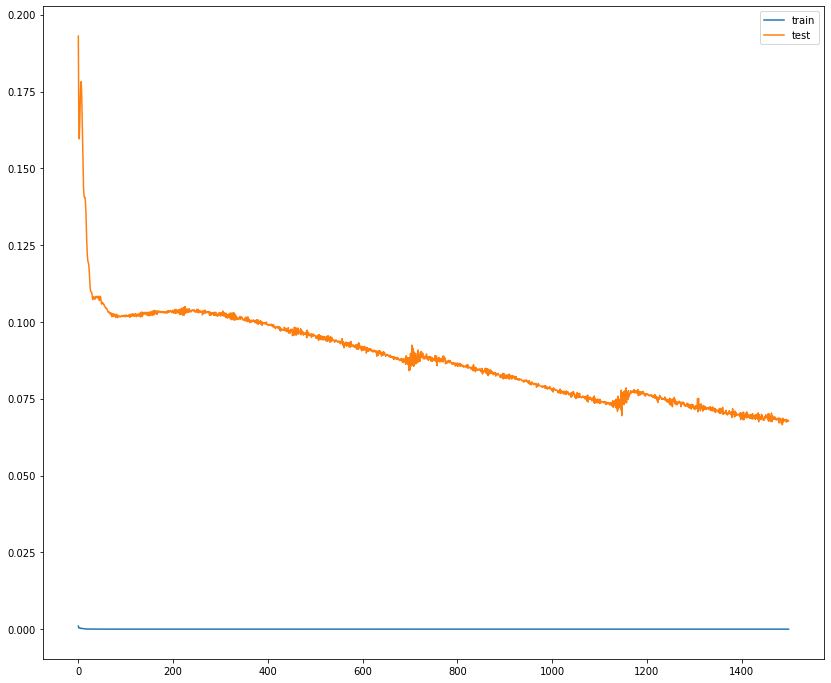

In [108]:
stateName = unique_states[8]
dataset =list_state_all[8]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
print(np.shape(scaled))
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#LSTM + CNN
subsequences = 1
timesteps = train_X.shape[1]
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_valid_series_sub.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=1500, verbose=2)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction (LSTM + CNN)
y_predict = model.predict(X_valid_series_sub)
test_X = X_valid_series_sub.reshape((X_valid_series_sub.shape[0], X_valid_series_sub.shape[2]))

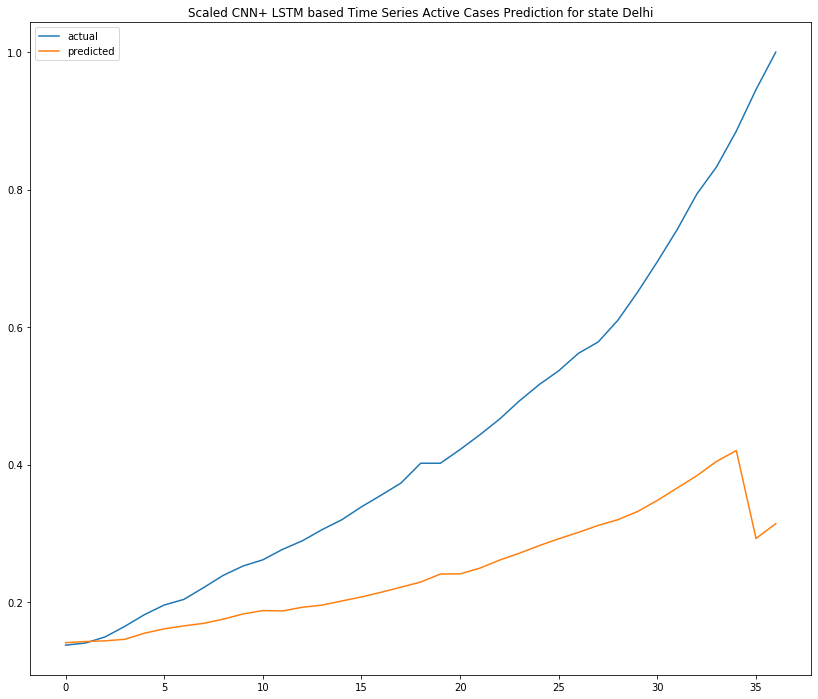

Test RMSE: 6508.431


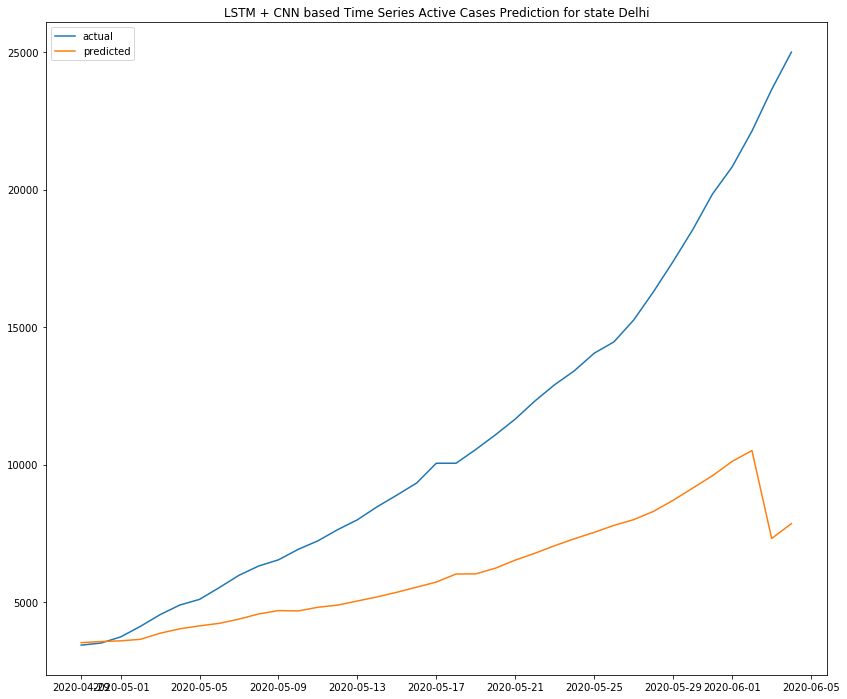

In [109]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled CNN+ LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
#rmse = np.sqrt(mean_squared_error(test_y, y_predict))
#print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM + CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# CNN based Prediction for Maharashtra with all features

No of features 22
(58, 23, 1) (58,) (30, 23, 1) (30,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 22, 64)            192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 64)            8256      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               32100     
_________________________________________________________________


1/1 - 0s - loss: 5.3028e-06 - val_loss: 0.0850
Epoch 115/2000
1/1 - 0s - loss: 5.2672e-06 - val_loss: 0.0849
Epoch 116/2000
1/1 - 0s - loss: 5.2151e-06 - val_loss: 0.0848
Epoch 117/2000
1/1 - 0s - loss: 5.1576e-06 - val_loss: 0.0847
Epoch 118/2000
1/1 - 0s - loss: 5.1126e-06 - val_loss: 0.0846
Epoch 119/2000
1/1 - 0s - loss: 5.0782e-06 - val_loss: 0.0844
Epoch 120/2000
1/1 - 0s - loss: 5.0384e-06 - val_loss: 0.0843
Epoch 121/2000
1/1 - 0s - loss: 4.9904e-06 - val_loss: 0.0841
Epoch 122/2000
1/1 - 0s - loss: 4.9442e-06 - val_loss: 0.0839
Epoch 123/2000
1/1 - 0s - loss: 4.9056e-06 - val_loss: 0.0838
Epoch 124/2000
1/1 - 0s - loss: 4.8703e-06 - val_loss: 0.0837
Epoch 125/2000
1/1 - 0s - loss: 4.8312e-06 - val_loss: 0.0836
Epoch 126/2000
1/1 - 0s - loss: 4.7910e-06 - val_loss: 0.0835
Epoch 127/2000
1/1 - 0s - loss: 4.7580e-06 - val_loss: 0.0834
Epoch 128/2000
1/1 - 0s - loss: 4.7291e-06 - val_loss: 0.0832
Epoch 129/2000
1/1 - 0s - loss: 4.6986e-06 - val_loss: 0.0831
Epoch 130/2000
1/1 - 0s

Epoch 247/2000
1/1 - 0s - loss: 2.9705e-06 - val_loss: 0.0736
Epoch 248/2000
1/1 - 0s - loss: 2.9657e-06 - val_loss: 0.0735
Epoch 249/2000
1/1 - 0s - loss: 2.9607e-06 - val_loss: 0.0735
Epoch 250/2000
1/1 - 0s - loss: 2.9559e-06 - val_loss: 0.0734
Epoch 251/2000
1/1 - 0s - loss: 2.9511e-06 - val_loss: 0.0734
Epoch 252/2000
1/1 - 0s - loss: 2.9462e-06 - val_loss: 0.0733
Epoch 253/2000
1/1 - 0s - loss: 2.9421e-06 - val_loss: 0.0733
Epoch 254/2000
1/1 - 0s - loss: 2.9380e-06 - val_loss: 0.0732
Epoch 255/2000
1/1 - 0s - loss: 2.9341e-06 - val_loss: 0.0732
Epoch 256/2000
1/1 - 0s - loss: 2.9302e-06 - val_loss: 0.0731
Epoch 257/2000
1/1 - 0s - loss: 2.9263e-06 - val_loss: 0.0731
Epoch 258/2000
1/1 - 0s - loss: 2.9224e-06 - val_loss: 0.0730
Epoch 259/2000
1/1 - 0s - loss: 2.9186e-06 - val_loss: 0.0730
Epoch 260/2000
1/1 - 0s - loss: 2.9149e-06 - val_loss: 0.0729
Epoch 261/2000
1/1 - 0s - loss: 2.9113e-06 - val_loss: 0.0729
Epoch 262/2000
1/1 - 0s - loss: 2.9078e-06 - val_loss: 0.0729
Epoch 26

1/1 - 0s - loss: 2.6351e-06 - val_loss: 0.0698
Epoch 380/2000
1/1 - 0s - loss: 2.6336e-06 - val_loss: 0.0697
Epoch 381/2000
1/1 - 0s - loss: 2.6321e-06 - val_loss: 0.0697
Epoch 382/2000
1/1 - 0s - loss: 2.6307e-06 - val_loss: 0.0697
Epoch 383/2000
1/1 - 0s - loss: 2.6292e-06 - val_loss: 0.0697
Epoch 384/2000
1/1 - 0s - loss: 2.6277e-06 - val_loss: 0.0697
Epoch 385/2000
1/1 - 0s - loss: 2.6263e-06 - val_loss: 0.0696
Epoch 386/2000
1/1 - 0s - loss: 2.6249e-06 - val_loss: 0.0696
Epoch 387/2000
1/1 - 0s - loss: 2.6235e-06 - val_loss: 0.0696
Epoch 388/2000
1/1 - 0s - loss: 2.6220e-06 - val_loss: 0.0696
Epoch 389/2000
1/1 - 0s - loss: 2.6205e-06 - val_loss: 0.0696
Epoch 390/2000
1/1 - 0s - loss: 2.6191e-06 - val_loss: 0.0695
Epoch 391/2000
1/1 - 0s - loss: 2.6177e-06 - val_loss: 0.0695
Epoch 392/2000
1/1 - 0s - loss: 2.6164e-06 - val_loss: 0.0695
Epoch 393/2000
1/1 - 0s - loss: 2.6150e-06 - val_loss: 0.0695
Epoch 394/2000
1/1 - 0s - loss: 2.6137e-06 - val_loss: 0.0695
Epoch 395/2000
1/1 - 0s

Epoch 512/2000
1/1 - 0s - loss: 2.4835e-06 - val_loss: 0.0676
Epoch 513/2000
1/1 - 0s - loss: 2.4827e-06 - val_loss: 0.0676
Epoch 514/2000
1/1 - 0s - loss: 2.4818e-06 - val_loss: 0.0676
Epoch 515/2000
1/1 - 0s - loss: 2.4809e-06 - val_loss: 0.0676
Epoch 516/2000
1/1 - 0s - loss: 2.4801e-06 - val_loss: 0.0675
Epoch 517/2000
1/1 - 0s - loss: 2.4791e-06 - val_loss: 0.0675
Epoch 518/2000
1/1 - 0s - loss: 2.4784e-06 - val_loss: 0.0675
Epoch 519/2000
1/1 - 0s - loss: 2.4775e-06 - val_loss: 0.0675
Epoch 520/2000
1/1 - 0s - loss: 2.4765e-06 - val_loss: 0.0675
Epoch 521/2000
1/1 - 0s - loss: 2.4758e-06 - val_loss: 0.0675
Epoch 522/2000
1/1 - 0s - loss: 2.4748e-06 - val_loss: 0.0675
Epoch 523/2000
1/1 - 0s - loss: 2.4739e-06 - val_loss: 0.0674
Epoch 524/2000
1/1 - 0s - loss: 2.4730e-06 - val_loss: 0.0674
Epoch 525/2000
1/1 - 0s - loss: 2.4723e-06 - val_loss: 0.0674
Epoch 526/2000
1/1 - 0s - loss: 2.4716e-06 - val_loss: 0.0674
Epoch 527/2000
1/1 - 0s - loss: 2.4705e-06 - val_loss: 0.0674
Epoch 52

1/1 - 0s - loss: 2.3363e-06 - val_loss: 0.0655
Epoch 645/2000
1/1 - 0s - loss: 2.3353e-06 - val_loss: 0.0655
Epoch 646/2000
1/1 - 0s - loss: 2.3343e-06 - val_loss: 0.0655
Epoch 647/2000
1/1 - 0s - loss: 2.3335e-06 - val_loss: 0.0655
Epoch 648/2000
1/1 - 0s - loss: 2.3329e-06 - val_loss: 0.0655
Epoch 649/2000
1/1 - 0s - loss: 2.3315e-06 - val_loss: 0.0654
Epoch 650/2000
1/1 - 0s - loss: 2.3307e-06 - val_loss: 0.0654
Epoch 651/2000
1/1 - 0s - loss: 2.3299e-06 - val_loss: 0.0654
Epoch 652/2000
1/1 - 0s - loss: 2.3289e-06 - val_loss: 0.0654
Epoch 653/2000
1/1 - 0s - loss: 2.3280e-06 - val_loss: 0.0654
Epoch 654/2000
1/1 - 0s - loss: 2.3271e-06 - val_loss: 0.0654
Epoch 655/2000
1/1 - 0s - loss: 2.3262e-06 - val_loss: 0.0653
Epoch 656/2000
1/1 - 0s - loss: 2.3254e-06 - val_loss: 0.0653
Epoch 657/2000
1/1 - 0s - loss: 2.3245e-06 - val_loss: 0.0653
Epoch 658/2000
1/1 - 0s - loss: 2.3238e-06 - val_loss: 0.0653
Epoch 659/2000
1/1 - 0s - loss: 2.3231e-06 - val_loss: 0.0653
Epoch 660/2000
1/1 - 0s

Epoch 777/2000
1/1 - 0s - loss: 2.2193e-06 - val_loss: 0.0633
Epoch 778/2000
1/1 - 0s - loss: 2.2184e-06 - val_loss: 0.0632
Epoch 779/2000
1/1 - 0s - loss: 2.2175e-06 - val_loss: 0.0632
Epoch 780/2000
1/1 - 0s - loss: 2.2167e-06 - val_loss: 0.0632
Epoch 781/2000
1/1 - 0s - loss: 2.2163e-06 - val_loss: 0.0632
Epoch 782/2000
1/1 - 0s - loss: 2.2152e-06 - val_loss: 0.0632
Epoch 783/2000
1/1 - 0s - loss: 2.2144e-06 - val_loss: 0.0632
Epoch 784/2000
1/1 - 0s - loss: 2.2139e-06 - val_loss: 0.0632
Epoch 785/2000
1/1 - 0s - loss: 2.2133e-06 - val_loss: 0.0632
Epoch 786/2000
1/1 - 0s - loss: 2.2125e-06 - val_loss: 0.0631
Epoch 787/2000
1/1 - 0s - loss: 2.2120e-06 - val_loss: 0.0631
Epoch 788/2000
1/1 - 0s - loss: 2.2111e-06 - val_loss: 0.0631
Epoch 789/2000
1/1 - 0s - loss: 2.2102e-06 - val_loss: 0.0631
Epoch 790/2000
1/1 - 0s - loss: 2.2092e-06 - val_loss: 0.0631
Epoch 791/2000
1/1 - 0s - loss: 2.2086e-06 - val_loss: 0.0631
Epoch 792/2000
1/1 - 0s - loss: 2.2077e-06 - val_loss: 0.0631
Epoch 79

1/1 - 0s - loss: 2.1175e-06 - val_loss: 0.0614
Epoch 910/2000
1/1 - 0s - loss: 2.1175e-06 - val_loss: 0.0614
Epoch 911/2000
1/1 - 0s - loss: 2.1161e-06 - val_loss: 0.0614
Epoch 912/2000
1/1 - 0s - loss: 2.1151e-06 - val_loss: 0.0614
Epoch 913/2000
1/1 - 0s - loss: 2.1151e-06 - val_loss: 0.0614
Epoch 914/2000
1/1 - 0s - loss: 2.1149e-06 - val_loss: 0.0614
Epoch 915/2000
1/1 - 0s - loss: 2.1136e-06 - val_loss: 0.0614
Epoch 916/2000
1/1 - 0s - loss: 2.1131e-06 - val_loss: 0.0614
Epoch 917/2000
1/1 - 0s - loss: 2.1110e-06 - val_loss: 0.0614
Epoch 918/2000
1/1 - 0s - loss: 2.1128e-06 - val_loss: 0.0614
Epoch 919/2000
1/1 - 0s - loss: 2.1103e-06 - val_loss: 0.0613
Epoch 920/2000
1/1 - 0s - loss: 2.1091e-06 - val_loss: 0.0613
Epoch 921/2000
1/1 - 0s - loss: 2.1088e-06 - val_loss: 0.0613
Epoch 922/2000
1/1 - 0s - loss: 2.1083e-06 - val_loss: 0.0613
Epoch 923/2000
1/1 - 0s - loss: 2.1070e-06 - val_loss: 0.0613
Epoch 924/2000
1/1 - 0s - loss: 2.1069e-06 - val_loss: 0.0613
Epoch 925/2000
1/1 - 0s

Epoch 1041/2000
1/1 - 0s - loss: 2.0125e-06 - val_loss: 0.0599
Epoch 1042/2000
1/1 - 0s - loss: 2.0123e-06 - val_loss: 0.0599
Epoch 1043/2000
1/1 - 0s - loss: 2.0121e-06 - val_loss: 0.0599
Epoch 1044/2000
1/1 - 0s - loss: 2.0105e-06 - val_loss: 0.0599
Epoch 1045/2000
1/1 - 0s - loss: 2.0107e-06 - val_loss: 0.0598
Epoch 1046/2000
1/1 - 0s - loss: 2.0091e-06 - val_loss: 0.0598
Epoch 1047/2000
1/1 - 0s - loss: 2.0075e-06 - val_loss: 0.0599
Epoch 1048/2000
1/1 - 0s - loss: 2.0096e-06 - val_loss: 0.0598
Epoch 1049/2000
1/1 - 0s - loss: 2.0059e-06 - val_loss: 0.0598
Epoch 1050/2000
1/1 - 0s - loss: 2.0057e-06 - val_loss: 0.0598
Epoch 1051/2000
1/1 - 0s - loss: 2.0052e-06 - val_loss: 0.0598
Epoch 1052/2000
1/1 - 0s - loss: 2.0038e-06 - val_loss: 0.0598
Epoch 1053/2000
1/1 - 0s - loss: 2.0023e-06 - val_loss: 0.0597
Epoch 1054/2000
1/1 - 0s - loss: 2.0039e-06 - val_loss: 0.0597
Epoch 1055/2000
1/1 - 0s - loss: 2.0024e-06 - val_loss: 0.0597
Epoch 1056/2000
1/1 - 0s - loss: 2.0017e-06 - val_loss:

1/1 - 0s - loss: 1.8977e-06 - val_loss: 0.0584
Epoch 1172/2000
1/1 - 0s - loss: 1.8948e-06 - val_loss: 0.0584
Epoch 1173/2000
1/1 - 0s - loss: 1.8940e-06 - val_loss: 0.0584
Epoch 1174/2000
1/1 - 0s - loss: 1.8975e-06 - val_loss: 0.0584
Epoch 1175/2000
1/1 - 0s - loss: 1.8952e-06 - val_loss: 0.0584
Epoch 1176/2000
1/1 - 0s - loss: 1.8917e-06 - val_loss: 0.0584
Epoch 1177/2000
1/1 - 0s - loss: 1.8915e-06 - val_loss: 0.0584
Epoch 1178/2000
1/1 - 0s - loss: 1.8889e-06 - val_loss: 0.0584
Epoch 1179/2000
1/1 - 0s - loss: 1.8870e-06 - val_loss: 0.0584
Epoch 1180/2000
1/1 - 0s - loss: 1.8907e-06 - val_loss: 0.0584
Epoch 1181/2000
1/1 - 0s - loss: 1.8895e-06 - val_loss: 0.0584
Epoch 1182/2000
1/1 - 0s - loss: 1.8858e-06 - val_loss: 0.0583
Epoch 1183/2000
1/1 - 0s - loss: 1.8834e-06 - val_loss: 0.0583
Epoch 1184/2000
1/1 - 0s - loss: 1.8868e-06 - val_loss: 0.0583
Epoch 1185/2000
1/1 - 0s - loss: 1.8832e-06 - val_loss: 0.0583
Epoch 1186/2000
1/1 - 0s - loss: 1.8773e-06 - val_loss: 0.0583
Epoch 11

Epoch 1302/2000
1/1 - 0s - loss: 1.7512e-06 - val_loss: 0.0570
Epoch 1303/2000
1/1 - 0s - loss: 1.7495e-06 - val_loss: 0.0571
Epoch 1304/2000
1/1 - 0s - loss: 1.7507e-06 - val_loss: 0.0570
Epoch 1305/2000
1/1 - 0s - loss: 1.7491e-06 - val_loss: 0.0571
Epoch 1306/2000
1/1 - 0s - loss: 1.7511e-06 - val_loss: 0.0570
Epoch 1307/2000
1/1 - 0s - loss: 1.7452e-06 - val_loss: 0.0570
Epoch 1308/2000
1/1 - 0s - loss: 1.7427e-06 - val_loss: 0.0570
Epoch 1309/2000
1/1 - 0s - loss: 1.7440e-06 - val_loss: 0.0570
Epoch 1310/2000
1/1 - 0s - loss: 1.7440e-06 - val_loss: 0.0570
Epoch 1311/2000
1/1 - 0s - loss: 1.7375e-06 - val_loss: 0.0569
Epoch 1312/2000
1/1 - 0s - loss: 1.7386e-06 - val_loss: 0.0569
Epoch 1313/2000
1/1 - 0s - loss: 1.7366e-06 - val_loss: 0.0569
Epoch 1314/2000
1/1 - 0s - loss: 1.7347e-06 - val_loss: 0.0569
Epoch 1315/2000
1/1 - 0s - loss: 1.7382e-06 - val_loss: 0.0569
Epoch 1316/2000
1/1 - 0s - loss: 1.7383e-06 - val_loss: 0.0569
Epoch 1317/2000
1/1 - 0s - loss: 1.7340e-06 - val_loss:

1/1 - 0s - loss: 1.5961e-06 - val_loss: 0.0559
Epoch 1433/2000
1/1 - 0s - loss: 1.5731e-06 - val_loss: 0.0559
Epoch 1434/2000
1/1 - 0s - loss: 1.5684e-06 - val_loss: 0.0559
Epoch 1435/2000
1/1 - 0s - loss: 1.5850e-06 - val_loss: 0.0560
Epoch 1436/2000
1/1 - 0s - loss: 1.6098e-06 - val_loss: 0.0558
Epoch 1437/2000
1/1 - 0s - loss: 1.6226e-06 - val_loss: 0.0560
Epoch 1438/2000
1/1 - 0s - loss: 1.6192e-06 - val_loss: 0.0558
Epoch 1439/2000
1/1 - 0s - loss: 1.5901e-06 - val_loss: 0.0559
Epoch 1440/2000
1/1 - 0s - loss: 1.5609e-06 - val_loss: 0.0558
Epoch 1441/2000
1/1 - 0s - loss: 1.5569e-06 - val_loss: 0.0558
Epoch 1442/2000
1/1 - 0s - loss: 1.5734e-06 - val_loss: 0.0559
Epoch 1443/2000
1/1 - 0s - loss: 1.5865e-06 - val_loss: 0.0558
Epoch 1444/2000
1/1 - 0s - loss: 1.5900e-06 - val_loss: 0.0559
Epoch 1445/2000
1/1 - 0s - loss: 1.5753e-06 - val_loss: 0.0558
Epoch 1446/2000
1/1 - 0s - loss: 1.5516e-06 - val_loss: 0.0558
Epoch 1447/2000
1/1 - 0s - loss: 1.5463e-06 - val_loss: 0.0558
Epoch 14

Epoch 1563/2000
1/1 - 0s - loss: 1.3836e-06 - val_loss: 0.0542
Epoch 1564/2000
1/1 - 0s - loss: 1.3975e-06 - val_loss: 0.0543
Epoch 1565/2000
1/1 - 0s - loss: 1.4323e-06 - val_loss: 0.0541
Epoch 1566/2000
1/1 - 0s - loss: 1.4903e-06 - val_loss: 0.0543
Epoch 1567/2000
1/1 - 0s - loss: 1.6257e-06 - val_loss: 0.0540
Epoch 1568/2000
1/1 - 0s - loss: 1.7666e-06 - val_loss: 0.0543
Epoch 1569/2000
1/1 - 0s - loss: 1.9080e-06 - val_loss: 0.0539
Epoch 1570/2000
1/1 - 0s - loss: 1.9469e-06 - val_loss: 0.0543
Epoch 1571/2000
1/1 - 0s - loss: 1.9766e-06 - val_loss: 0.0539
Epoch 1572/2000
1/1 - 0s - loss: 1.8123e-06 - val_loss: 0.0542
Epoch 1573/2000
1/1 - 0s - loss: 1.5765e-06 - val_loss: 0.0541
Epoch 1574/2000
1/1 - 0s - loss: 1.3985e-06 - val_loss: 0.0541
Epoch 1575/2000
1/1 - 0s - loss: 1.3879e-06 - val_loss: 0.0542
Epoch 1576/2000
1/1 - 0s - loss: 1.5011e-06 - val_loss: 0.0540
Epoch 1577/2000
1/1 - 0s - loss: 1.6376e-06 - val_loss: 0.0543
Epoch 1578/2000
1/1 - 0s - loss: 1.7290e-06 - val_loss:

1/1 - 0s - loss: 1.2102e-06 - val_loss: 0.0529
Epoch 1694/2000
1/1 - 0s - loss: 1.2153e-06 - val_loss: 0.0528
Epoch 1695/2000
1/1 - 0s - loss: 1.2381e-06 - val_loss: 0.0529
Epoch 1696/2000
1/1 - 0s - loss: 1.2802e-06 - val_loss: 0.0527
Epoch 1697/2000
1/1 - 0s - loss: 1.3178e-06 - val_loss: 0.0530
Epoch 1698/2000
1/1 - 0s - loss: 1.3491e-06 - val_loss: 0.0527
Epoch 1699/2000
1/1 - 0s - loss: 1.3479e-06 - val_loss: 0.0529
Epoch 1700/2000
1/1 - 0s - loss: 1.3179e-06 - val_loss: 0.0527
Epoch 1701/2000
1/1 - 0s - loss: 1.2735e-06 - val_loss: 0.0529
Epoch 1702/2000
1/1 - 0s - loss: 1.2466e-06 - val_loss: 0.0527
Epoch 1703/2000
1/1 - 0s - loss: 1.2238e-06 - val_loss: 0.0528
Epoch 1704/2000
1/1 - 0s - loss: 1.2070e-06 - val_loss: 0.0528
Epoch 1705/2000
1/1 - 0s - loss: 1.2013e-06 - val_loss: 0.0528
Epoch 1706/2000
1/1 - 0s - loss: 1.1965e-06 - val_loss: 0.0528
Epoch 1707/2000
1/1 - 0s - loss: 1.1915e-06 - val_loss: 0.0527
Epoch 1708/2000
1/1 - 0s - loss: 1.1944e-06 - val_loss: 0.0528
Epoch 17

Epoch 1824/2000
1/1 - 0s - loss: 1.1738e-06 - val_loss: 0.0515
Epoch 1825/2000
1/1 - 0s - loss: 1.2430e-06 - val_loss: 0.0519
Epoch 1826/2000
1/1 - 0s - loss: 1.3027e-06 - val_loss: 0.0515
Epoch 1827/2000
1/1 - 0s - loss: 1.3166e-06 - val_loss: 0.0519
Epoch 1828/2000
1/1 - 0s - loss: 1.2896e-06 - val_loss: 0.0515
Epoch 1829/2000
1/1 - 0s - loss: 1.2231e-06 - val_loss: 0.0518
Epoch 1830/2000
1/1 - 0s - loss: 1.1452e-06 - val_loss: 0.0516
Epoch 1831/2000
1/1 - 0s - loss: 1.0901e-06 - val_loss: 0.0517
Epoch 1832/2000
1/1 - 0s - loss: 1.0569e-06 - val_loss: 0.0516
Epoch 1833/2000
1/1 - 0s - loss: 1.0347e-06 - val_loss: 0.0517
Epoch 1834/2000
1/1 - 0s - loss: 1.0253e-06 - val_loss: 0.0517
Epoch 1835/2000
1/1 - 0s - loss: 1.0219e-06 - val_loss: 0.0516
Epoch 1836/2000
1/1 - 0s - loss: 1.0191e-06 - val_loss: 0.0517
Epoch 1837/2000
1/1 - 0s - loss: 1.0242e-06 - val_loss: 0.0516
Epoch 1838/2000
1/1 - 0s - loss: 1.0398e-06 - val_loss: 0.0517
Epoch 1839/2000
1/1 - 0s - loss: 1.0583e-06 - val_loss:

1/1 - 0s - loss: 9.1185e-07 - val_loss: 0.0510
Epoch 1955/2000
1/1 - 0s - loss: 8.9977e-07 - val_loss: 0.0509
Epoch 1956/2000
1/1 - 0s - loss: 8.9499e-07 - val_loss: 0.0509
Epoch 1957/2000
1/1 - 0s - loss: 8.9814e-07 - val_loss: 0.0510
Epoch 1958/2000
1/1 - 0s - loss: 9.1090e-07 - val_loss: 0.0508
Epoch 1959/2000
1/1 - 0s - loss: 9.2887e-07 - val_loss: 0.0510
Epoch 1960/2000
1/1 - 0s - loss: 9.4897e-07 - val_loss: 0.0507
Epoch 1961/2000
1/1 - 0s - loss: 9.6669e-07 - val_loss: 0.0510
Epoch 1962/2000
1/1 - 0s - loss: 9.9075e-07 - val_loss: 0.0507
Epoch 1963/2000
1/1 - 0s - loss: 9.9678e-07 - val_loss: 0.0510
Epoch 1964/2000
1/1 - 0s - loss: 9.9761e-07 - val_loss: 0.0507
Epoch 1965/2000
1/1 - 0s - loss: 9.8294e-07 - val_loss: 0.0509
Epoch 1966/2000
1/1 - 0s - loss: 9.6266e-07 - val_loss: 0.0507
Epoch 1967/2000
1/1 - 0s - loss: 9.3812e-07 - val_loss: 0.0509
Epoch 1968/2000
1/1 - 0s - loss: 9.1540e-07 - val_loss: 0.0507
Epoch 1969/2000
1/1 - 0s - loss: 9.0462e-07 - val_loss: 0.0508
Epoch 19

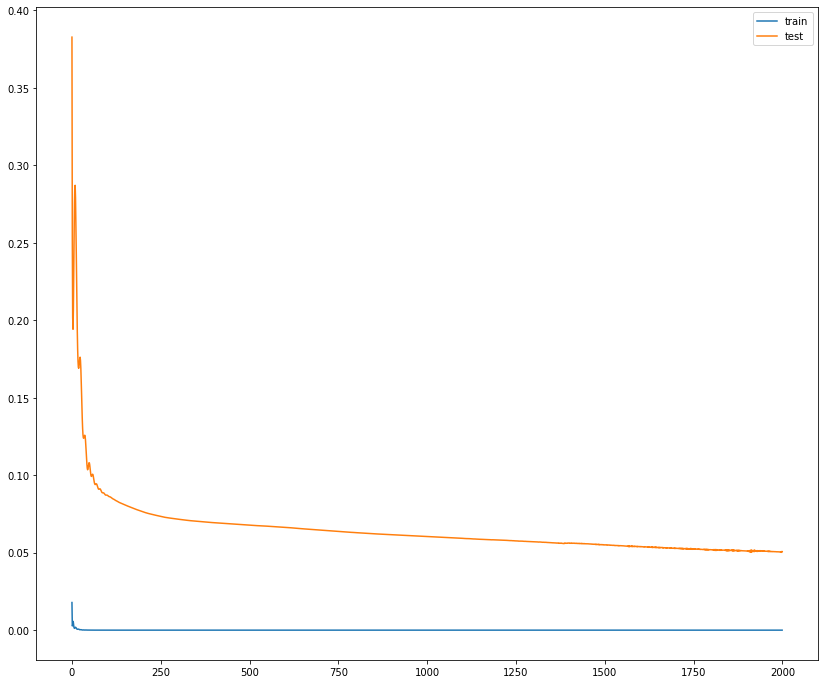

(58, 23, 1) (58,) (30, 23) (30,)


In [76]:
stateName = unique_states[19]
dataset =list_state_all[19]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]


dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]


#no_features = 22
no_features = np.shape(dataset)[1]-1
print("No of features", no_features)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Conversion of dataset for supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


#CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()


history =model.fit(train_X, train_y, epochs=2000, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

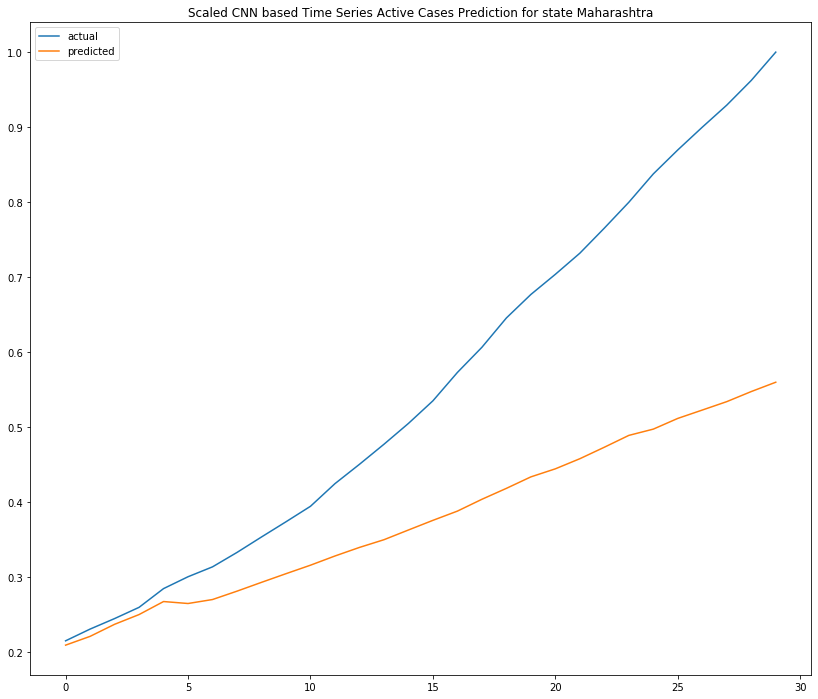

Test RMSE: 0.225
Test RMSE: 17520.787


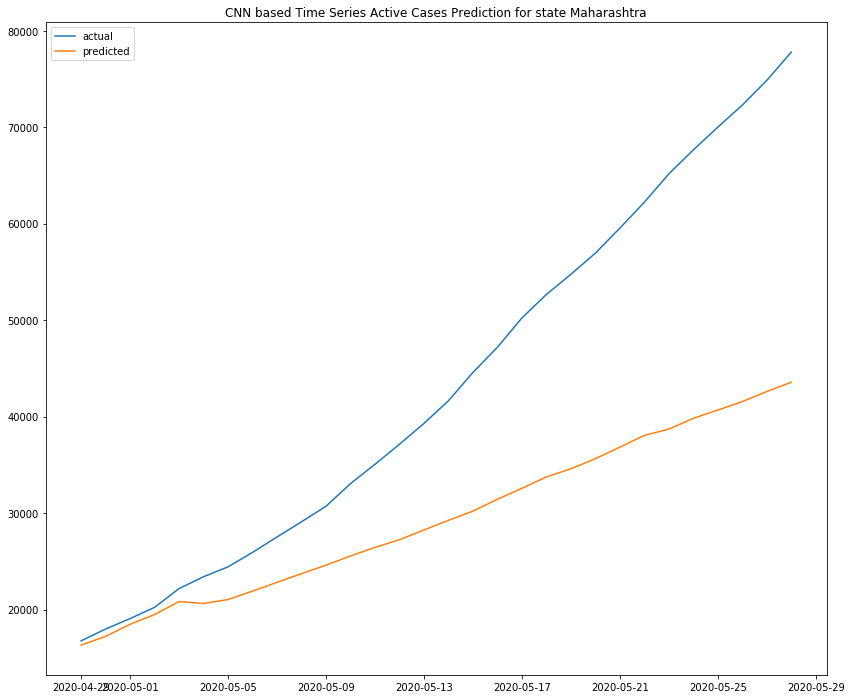

In [77]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# RMSE computation
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('CNN based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()

# LSTM based Prediction for Maharashtra with all features

In [78]:
stateName = unique_states[19]
dataset =list_state_all[19]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-01') & (dataset['Date'] <= '2020-06-06')]

daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]

dataset = dataset[['Total Confirmed cases','Death',
       'Cured/Discharged/Migrated', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive',
       'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed', 'Active Cases']]

#no_features = 22
no_features = np.shape(dataset)[1]-1
values = dataset.values


values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]], axis=1, inplace=True)


values = reframed.values
split_factor = int(dataset.shape[0]*0.6)
train = values[:split_factor, :]
test = values[split_factor:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Training and Testing data shapes", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

print(train_X.shape[1], train_X.shape[2])
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=1500, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)


y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print("After reshaping test dataset", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Training and Testing data shapes (58, 1, 23) (58,) (30, 1, 23) (30,)
1 23
Epoch 1/1500
1/1 - 1s - loss: 0.0286 - val_loss: 0.5129
Epoch 2/1500
1/1 - 0s - loss: 0.0266 - val_loss: 0.5029
Epoch 3/1500
1/1 - 0s - loss: 0.0260 - val_loss: 0.4945
Epoch 4/1500
1/1 - 0s - loss: 0.0255 - val_loss: 0.4870
Epoch 5/1500
1/1 - 0s - loss: 0.0248 - val_loss: 0.4804
Epoch 6/1500
1/1 - 0s - loss: 0.0239 - val_loss: 0.4743
Epoch 7/1500
1/1 - 0s - loss: 0.0229 - val_loss: 0.4683
Epoch 8/1500
1/1 - 0s - loss: 0.0224 - val_loss: 0.4621
Epoch 9/1500
1/1 - 0s - loss: 0.0225 - val_loss: 0.4550
Epoch 10/1500
1/1 - 0s - loss: 0.0224 - val_loss: 0.4471
Epoch 11/1500
1/1 - 0s - loss: 0.0221 - val_loss: 0.4390
Epoch 12/1500
1/1 - 0s - loss: 0.0215 - val_loss: 0.4311
Epoch 13/1500
1/1 - 0s - loss: 0.0210 - val_loss: 0.4238
Epoch 14/1500
1/1 - 0s - loss: 0.0208 - val_loss: 0.4174
Epoch 15/1500
1/1 - 0s - loss: 0.0205 - val_loss: 0.4118
Epoch 16/1500
1/1 - 0s - loss: 0.0202 - val_loss: 0.4069
Epoch 17/1500
1/1 - 0s 

Epoch 143/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0325
Epoch 144/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0311
Epoch 145/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0323
Epoch 146/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0309
Epoch 147/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0292
Epoch 148/1500
1/1 - 0s - loss: 0.0018 - val_loss: 0.0307
Epoch 149/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0339
Epoch 150/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.0329
Epoch 151/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0303
Epoch 152/1500
1/1 - 0s - loss: 0.0023 - val_loss: 0.0313
Epoch 153/1500
1/1 - 0s - loss: 0.0017 - val_loss: 0.0357
Epoch 154/1500
1/1 - 0s - loss: 0.0021 - val_loss: 0.0362
Epoch 155/1500
1/1 - 0s - loss: 0.0021 - val_loss: 0.0325
Epoch 156/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0316
Epoch 157/1500
1/1 - 0s - loss: 0.0019 - val_loss: 0.0338
Epoch 158/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0352
Epoch 159/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0337
Epoch 160/1500

1/1 - 0s - loss: 0.0013 - val_loss: 0.0328
Epoch 285/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0333
Epoch 286/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0354
Epoch 287/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0352
Epoch 288/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0337
Epoch 289/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0342
Epoch 290/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0358
Epoch 291/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0350
Epoch 292/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0331
Epoch 293/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0332
Epoch 294/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0342
Epoch 295/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0330
Epoch 296/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0323
Epoch 297/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0331
Epoch 298/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0349
Epoch 299/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0344
Epoch 300/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0348
Epoch 301/1500
1/1 - 0s - los

Epoch 426/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0305
Epoch 427/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0293
Epoch 428/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0292
Epoch 429/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0302
Epoch 430/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0291
Epoch 431/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0291
Epoch 432/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0303
Epoch 433/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0293
Epoch 434/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0290
Epoch 435/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0298
Epoch 436/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0285
Epoch 437/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0283
Epoch 438/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0290
Epoch 439/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0301
Epoch 440/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0291
Epoch 441/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0300
Epoch 442/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0319
Epoch 443/1500

1/1 - 0s - loss: 0.0013 - val_loss: 0.0219
Epoch 568/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0219
Epoch 569/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0228
Epoch 570/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0219
Epoch 571/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0219
Epoch 572/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0228
Epoch 573/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0220
Epoch 574/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0218
Epoch 575/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0223
Epoch 576/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0225
Epoch 577/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0231
Epoch 578/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0241
Epoch 579/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0233
Epoch 580/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0237
Epoch 581/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0246
Epoch 582/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0236
Epoch 583/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0236
Epoch 584/1500
1/1 - 0s - los

Epoch 709/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0235
Epoch 710/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0230
Epoch 711/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0238
Epoch 712/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0227
Epoch 713/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0228
Epoch 714/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0217
Epoch 715/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0216
Epoch 716/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0224
Epoch 717/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0220
Epoch 718/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0225
Epoch 719/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0232
Epoch 720/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0226
Epoch 721/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0231
Epoch 722/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0226
Epoch 723/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0221
Epoch 724/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0226
Epoch 725/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0219
Epoch 726/1500

1/1 - 0s - loss: 0.0016 - val_loss: 0.0185
Epoch 851/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0180
Epoch 852/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0189
Epoch 853/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0190
Epoch 854/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0176
Epoch 855/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0181
Epoch 856/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0184
Epoch 857/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0176
Epoch 858/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0178
Epoch 859/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0189
Epoch 860/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0183
Epoch 861/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0187
Epoch 862/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0199
Epoch 863/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0191
Epoch 864/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0171
Epoch 865/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0165
Epoch 866/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0160
Epoch 867/1500
1/1 - 0s - los

Epoch 992/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0180
Epoch 993/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.0158
Epoch 994/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0140
Epoch 995/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0137
Epoch 996/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0133
Epoch 997/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0135
Epoch 998/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0139
Epoch 999/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0144
Epoch 1000/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.0156
Epoch 1001/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0178
Epoch 1002/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0180
Epoch 1003/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0166
Epoch 1004/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.0172
Epoch 1005/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0199
Epoch 1006/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0197
Epoch 1007/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.0170
Epoch 1008/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0161
Epoch

Epoch 1131/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0138
Epoch 1132/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0142
Epoch 1133/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0136
Epoch 1134/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0139
Epoch 1135/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0135
Epoch 1136/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0135
Epoch 1137/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0135
Epoch 1138/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0142
Epoch 1139/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0136
Epoch 1140/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0138
Epoch 1141/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0144
Epoch 1142/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0135
Epoch 1143/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0127
Epoch 1144/1500
1/1 - 0s - loss: 0.0016 - val_loss: 0.0125
Epoch 1145/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0132
Epoch 1146/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0130
Epoch 1147/1500
1/1 - 0s - loss: 0.0014 - val_loss: 0.01

Epoch 1270/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0073
Epoch 1271/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0079
Epoch 1272/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0092
Epoch 1273/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0078
Epoch 1274/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0074
Epoch 1275/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0084
Epoch 1276/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0084
Epoch 1277/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0074
Epoch 1278/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0076
Epoch 1279/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0087
Epoch 1280/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0080
Epoch 1281/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0074
Epoch 1282/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0080
Epoch 1283/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0086
Epoch 1284/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0079
Epoch 1285/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0080
Epoch 1286/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.00

Epoch 1409/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0075
Epoch 1410/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0086
Epoch 1411/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0082
Epoch 1412/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0075
Epoch 1413/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0076
Epoch 1414/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0079
Epoch 1415/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0076
Epoch 1416/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0075
Epoch 1417/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0082
Epoch 1418/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0078
Epoch 1419/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0072
Epoch 1420/1500
1/1 - 0s - loss: 0.0013 - val_loss: 0.0077
Epoch 1421/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0089
Epoch 1422/1500
1/1 - 0s - loss: 0.0015 - val_loss: 0.0076
Epoch 1423/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.0072
Epoch 1424/1500
1/1 - 0s - loss: 0.0012 - val_loss: 0.0077
Epoch 1425/1500
1/1 - 0s - loss: 0.0011 - val_loss: 0.00

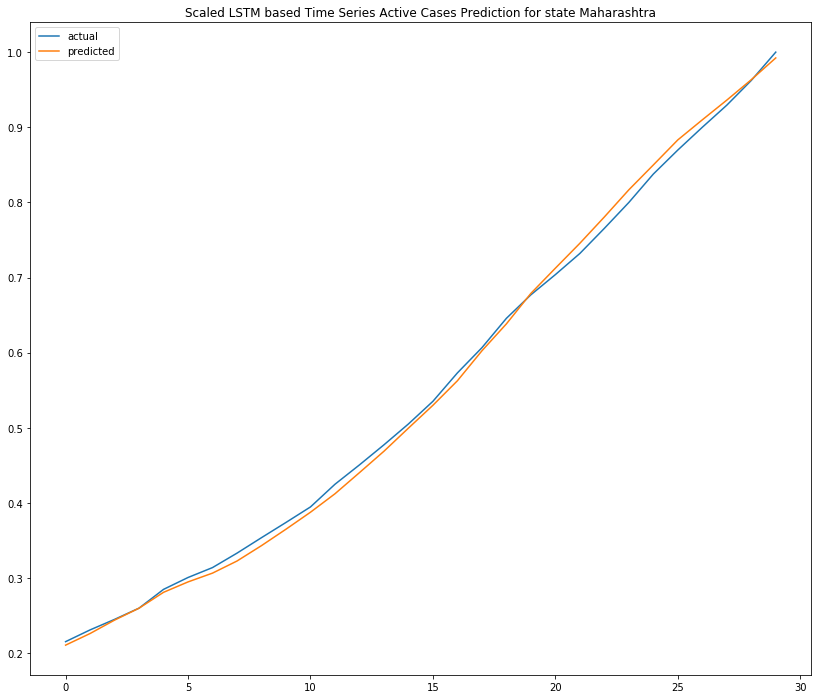

Test RMSE: 0.009
Test RMSE: 694.060


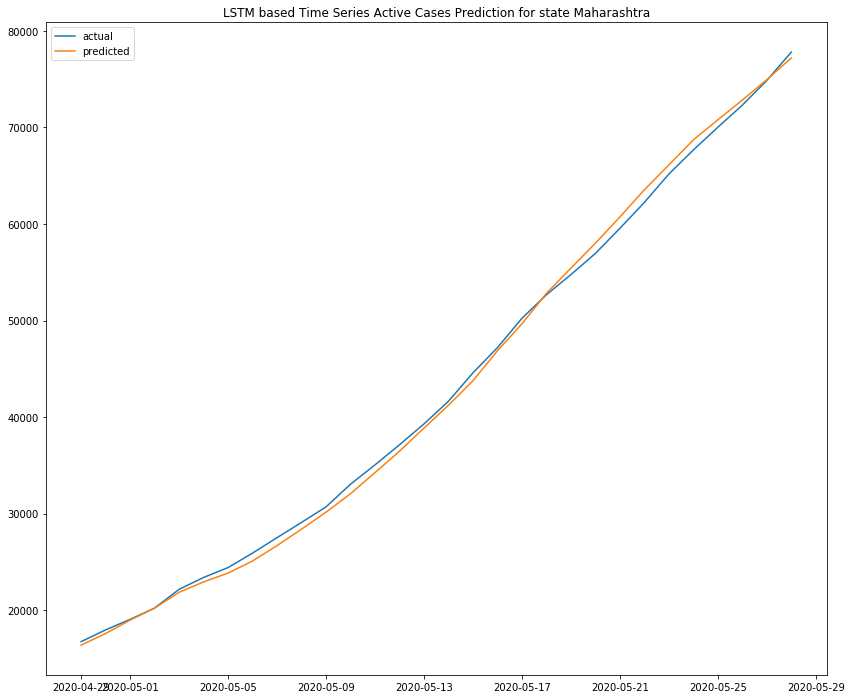

In [79]:
plt.figure(figsize=(14,12))
plt.plot(test_y, label='actual')
plt.plot(y_predict, label='predicted')
plt.title('Scaled LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()
rmse = np.sqrt(mean_squared_error(test_y, y_predict))
print('Test RMSE: %.3f' % rmse)


inv_y_predict = concatenate((y_predict, test_X[:, -(no_features):]), axis=1)

inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)

pred_len = len(inv_y_predict)
dateEnd = daterange[split_factor+1]
pred_index= pd.date_range(start=dateEnd, periods=pred_len, freq='D')

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_y_predict, pred_index)


plt.figure(figsize=(14,12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title('LSTM based Time Series Active Cases Prediction for state ' + stateName)
plt.legend()
plt.show()